<h1 style="color:BLUE;"> Walmart Sales Prediction Project </h1>

A retail store has multiple outlets across the country that are facing issues in managing their inventory. Our objective is to assist them to match demand with supply in a more predictive manner using predictive techniques.

* Below highlighted in Red in the notebook regarding both the questions and answers. 

<table>
  <tr>
    <td>
      <img src="Walmart.jpg" width="400" height="200">
    </td>
    <td>
      <img src="FLD.jpeg" width="50" height="25">
    </td>
  </tr>
</table>


## The data

| Column | Description |
|---|:---|
| Store         | Store number |
| Date          | Week of Sales |
| Weekly_Sales  | Sales for the given store in that week |
| Holiday_Flag  | If it is a holiday week |
| Temperature   | Temperature on the day of the sale |
| Fuel_price    | Cost of the fuel in the region |
| CPI           | Consumer Price Index |
| Unemployment  | Unemployment Rate |


In [1]:
# Importing the necessary libraries

import os
# print the location of the directory
print(os.getcwd())
import numpy as np

import pandas as pd
from pandas.plotting import autocorrelation_plot


import matplotlib
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

import plotly.express as px

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX


import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

import scipy.stats as stats

from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

C:\Users\Frederick Duff\Desktop\MIT-Data-Engineering\Walmart


In [2]:
# printing the versions of the libraries used for this notebook.
print('Numpy version:',np.__version__)
print('Pandas version:',pd.__version__)
print('Seaborn version:',sns.__version__)
print('Sklearn version:',sklearn.__version__)
print('Statsmodels version:',statsmodels.__version__)
print('Matplotlib version:',matplotlib.__version__)


Numpy version: 1.24.3
Pandas version: 2.0.3
Seaborn version: 0.12.2
Sklearn version: 1.3.0
Statsmodels version: 0.14.0
Matplotlib version: 3.7.2


In [3]:
# read the dataset
df = pd.read_csv("Walmart DataSet.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
# copy of the dataset
df2 = df.copy()

In [5]:
rows, cols = df.shape  # Unpack the shape tuple into separate variables
print(f"The dataset has {rows} rows and {cols} columns")

The dataset has 6435 rows and 8 columns


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


_____________________
* Date is the index and is properly formated
* Store and Holiday_Flag are int64
* Weekly_Sales, Temperature, Fuel_Price, CPI, Unemployment are float64

In [7]:
# Identify number of columns by type

numerical_features = [feature for feature in df.columns if df[feature].dtypes != "O"]
discrete_features = [
    feature for feature in numerical_features if len(df[feature].unique()) < 25
]
continuous_features = [
    feature for feature in numerical_features if feature not in discrete_features
]
categorical_features = [
    feature for feature in df.columns if feature not in numerical_features
]
binary_categorical_features = [
    feature for feature in categorical_features if len(df[feature].unique()) <= 3
]
print("Numerical Features Count {}".format(len(numerical_features)))
print("Discrete features Count {}".format(len(discrete_features)))
print("Continuous features Count {}".format(len(continuous_features)))
print("Categorical features Count {}".format(len(categorical_features)))
print("Binary Categorical features Count {}".format(len(binary_categorical_features)))

Numerical Features Count 7
Discrete features Count 1
Continuous features Count 6
Categorical features Count 1
Binary Categorical features Count 0


In [8]:
# Let's see unique values
cols = df.columns

for col in cols:
    print("Unique values in the column '{}' are \n\n".format(col), df[col].unique())
    print("-" * 100)

Unique values in the column 'Store' are 

 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
----------------------------------------------------------------------------------------------------
Unique values in the column 'Date' are 

 ['05-02-2010' '12-02-2010' '19-02-2010' '26-02-2010' '05-03-2010'
 '12-03-2010' '19-03-2010' '26-03-2010' '02-04-2010' '09-04-2010'
 '16-04-2010' '23-04-2010' '30-04-2010' '07-05-2010' '14-05-2010'
 '21-05-2010' '28-05-2010' '04-06-2010' '11-06-2010' '18-06-2010'
 '25-06-2010' '02-07-2010' '09-07-2010' '16-07-2010' '23-07-2010'
 '30-07-2010' '06-08-2010' '13-08-2010' '20-08-2010' '27-08-2010'
 '03-09-2010' '10-09-2010' '17-09-2010' '24-09-2010' '01-10-2010'
 '08-10-2010' '15-10-2010' '22-10-2010' '29-10-2010' '05-11-2010'
 '12-11-2010' '19-11-2010' '26-11-2010' '03-12-2010' '10-12-2010'
 '17-12-2010' '24-12-2010' '31-12-2010' '07-01-2011' '14-01-2011'
 '21-01-2011' '2

In [9]:
# summary of unique values by count
df.nunique()

Store             45
Date             143
Weekly_Sales    6435
Holiday_Flag       2
Temperature     3528
Fuel_Price       892
CPI             2145
Unemployment     349
dtype: int64

<h2 style="color:BLUE;"> DATA PRE-PROCESSING </h2>

In [10]:
# checking for missing values

df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

* there are no missing observations

In [11]:
# Alter the Date column to take the index 
df.index = df['Date']
# now we will delete the duplicate column since Date is now the index
del df['Date']

In [12]:
# Looking at the first 5 rows
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
05-02-2010,1,1643690.90,0,42.31,2.572,211.096358,8.106
12-02-2010,1,1641957.44,1,38.51,2.548,211.242170,8.106
19-02-2010,1,1611968.17,0,39.93,2.514,211.289143,8.106
26-02-2010,1,1409727.59,0,46.63,2.561,211.319643,8.106
05-03-2010,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [13]:
# Looking at the last 5 rows
df.tail()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
28-09-2012,45,713173.95,0,64.88,3.997,192.013558,8.684
05-10-2012,45,733455.07,0,64.89,3.985,192.170412,8.667
12-10-2012,45,734464.36,0,54.47,4.000,192.327265,8.667
19-10-2012,45,718125.53,0,56.47,3.969,192.330854,8.667
26-10-2012,45,760281.43,0,58.85,3.882,192.308899,8.667


<h2 style="color:BLUE;"> EDA </h2>

In [14]:
# statistical summary of data
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Store,6435.0,2.300000e+01,12.988182,1.000,12.000,23.000000,3.400000e+01,4.500000e+01
Weekly_Sales,6435.0,1.046965e+06,564366.622054,209986.250,553350.105,960746.040000,1.420159e+06,3.818686e+06
Holiday_Flag,6435.0,6.993007e-02,0.255049,0.000,0.000,0.000000,0.000000e+00,1.000000e+00
Temperature,6435.0,6.066378e+01,18.444933,-2.060,47.460,62.670000,7.494000e+01,1.001400e+02
Fuel_Price,6435.0,3.358607e+00,0.459020,2.472,2.933,3.445000,3.735000e+00,4.468000e+00
CPI,6435.0,1.715784e+02,39.356712,126.064,131.735,182.616521,2.127433e+02,2.272328e+02
Unemployment,6435.0,7.999151e+00,1.875885,3.879,6.891,7.874000,8.622000e+00,1.431300e+01


In [15]:
skewness = df.skew()
print("Skewness:", skewness)

Skewness: Store           0.000000
Weekly_Sales    0.668362
Holiday_Flag    3.373499
Temperature    -0.336768
Fuel_Price     -0.096158
CPI             0.063492
Unemployment    1.188144
dtype: float64


#### Some insights from Skewness observed numerically - These are merely assumptions before viewing the graphs and we will graph these observations to gain insight in the accuracy ( or inaccuracy) of these statements
* Store- symmetric distribution with a even distribution consistant with the nature of the observation
* Weekly_Sales- .668362 shows a moderately positive skew. The distribution has a slightly longer tail on the right showing that 
there are higher values( outliers) pulling the mean to the right of the median. These outliers may have some important insight
* Holiday_Flag- 3.3734399 shows a STRONG POSITIVE SKEW- The distribution has a very long tail on the right , showing that most values
are concentrated on the lower end with very few high values
* Temperature- -.336768 this is a mildly negative skew indicating that there are some lower values that pull the mean to the left of the median
* Fuel_Price- - .096158 very mild negative skew- almost symmetric but a slightly longer left tail
* CPI- .063492 almost symmetric, close to a bell shaped distribution
* Unemployment- 1.188144 Mild postive skew- longer tail on the right indicating that some higher values that pull the mean to the right of the median. 

### Univariate Analysis

In [16]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(10, 6), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [17]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(data=data, x=feature, palette="Paired", order=data[feature].value_counts().index[:n].sort_values())

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(100 * p.get_height() / total)  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()      # height of the plot

        ax.annotate(label, (x, y), ha="center", va="center", size=12, xytext=(0, 5), textcoords="offset points")  # annotate the percentage

    plt.show()  # show the plot

### Store

In [18]:
countofstore = df["Store"].count()
print("There are ",countofstore,"store's in this dataset ")

There are  6435 store's in this dataset 


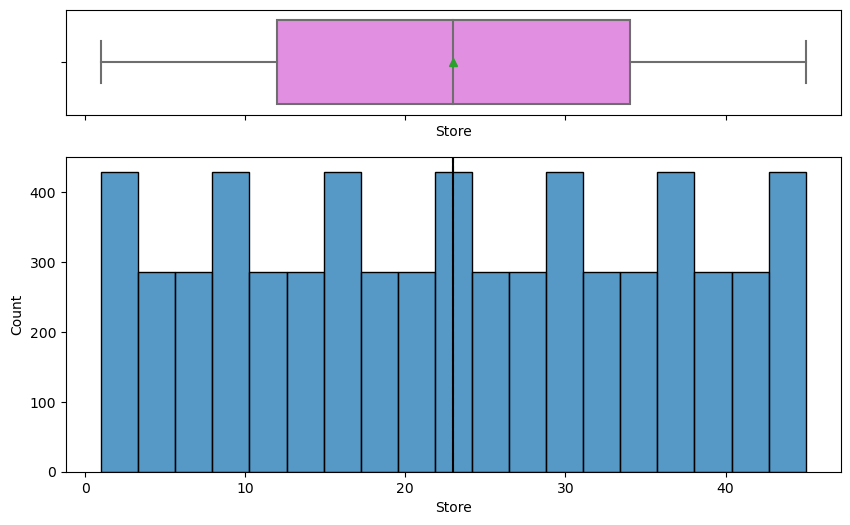

In [19]:
histogram_boxplot(df2,"Store")

* Evenly distributed - makes sense due to the nature of this variable as it describes each individual store

### Weekly_Sales

Mean:  1046964.8775617715 
Median:  960746.04 
Mode:  209986.25


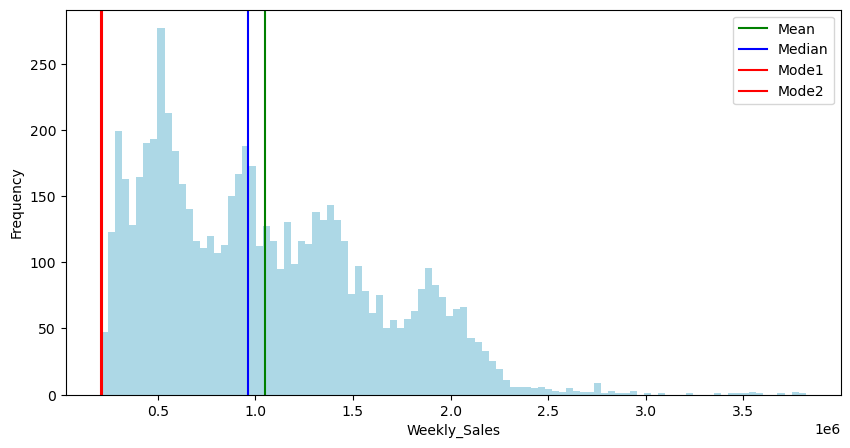

In [20]:
mean=df['Weekly_Sales'].mean()
median=df['Weekly_Sales'].median()
mode=df['Weekly_Sales'].mode()

print('Mean: ',mean,'\nMedian: ',median,'\nMode: ',mode[0])

plt.figure(figsize=(10,5)) # set the figure size
plt.hist(df['Weekly_Sales'],bins=100,color='lightblue') #Plot the histogram

plt.axvline(mean,color='green',label='Mean') # Draw lines on the plot for mean median and the two modes we have in Weekly_Sales
plt.axvline(median,color='blue',label='Median')
plt.axvline(mode[0],color='red',label='Mode1')
plt.axvline(mode[1],color='red',label='Mode2')

plt.xlabel('Weekly_Sales')   # label the x-axis
plt.ylabel('Frequency')   # label the y-axis
plt.legend()              # Plot the legend
plt.show()

<Axes: xlabel='Date'>

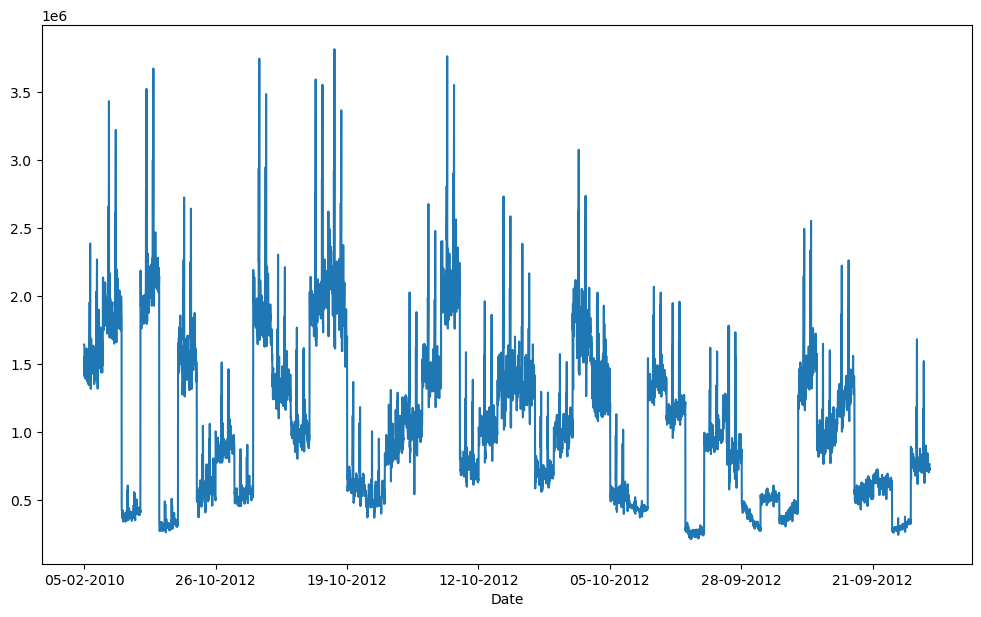

In [21]:
plt.figure(figsize=(12,7)) # set the figure size
df['Weekly_Sales'].plot()

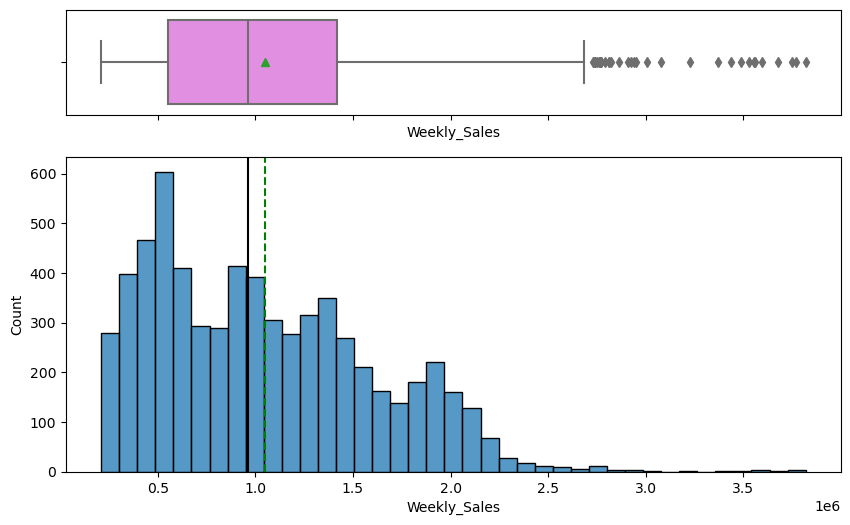

In [22]:
histogram_boxplot(df2,"Weekly_Sales")

### Holiday_Flag

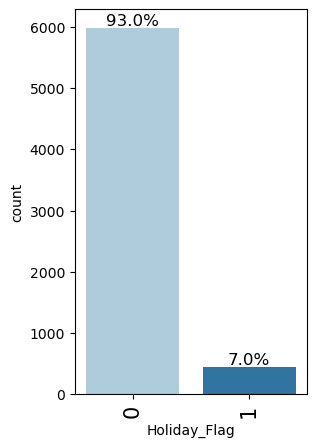

In [23]:
labeled_barplot(df,'Holiday_Flag',perc = True)

* 7 percent of the observed dates indicate a Holiday, it will be meaningful to see the sales to Holiday evaluation and compare 

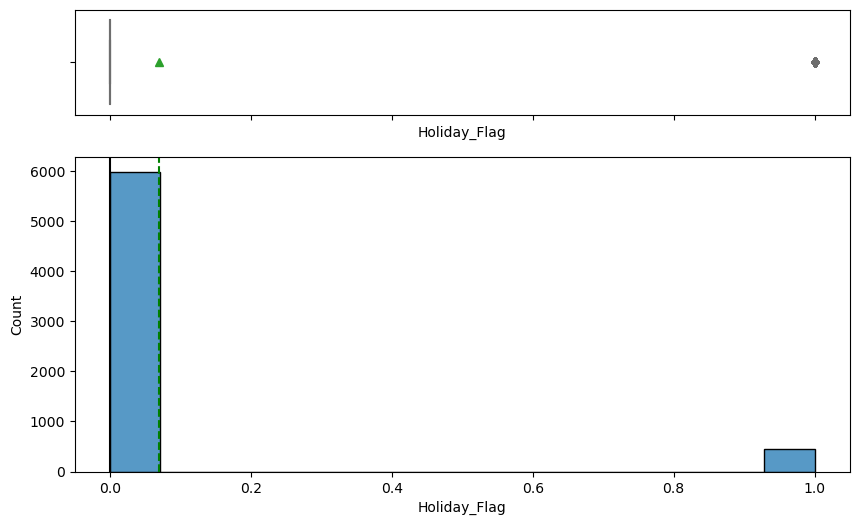

In [24]:
histogram_boxplot(df2,"Holiday_Flag")

* clearly most observations are not Holiday's so there is a strong positive skew logically . 

### Temperature

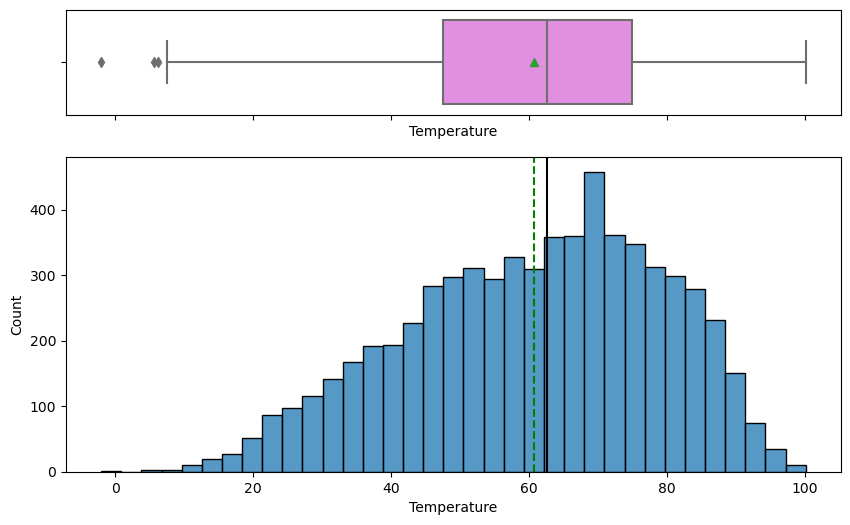

In [25]:
histogram_boxplot(df2,"Temperature")

* We see that this supports the earlier skew showing a mild negative skew
* "Temperature- -.336768 this is a mildly negative skew indicating that there are some lower values that pull the mean to the left of the median."

### Fuel Price

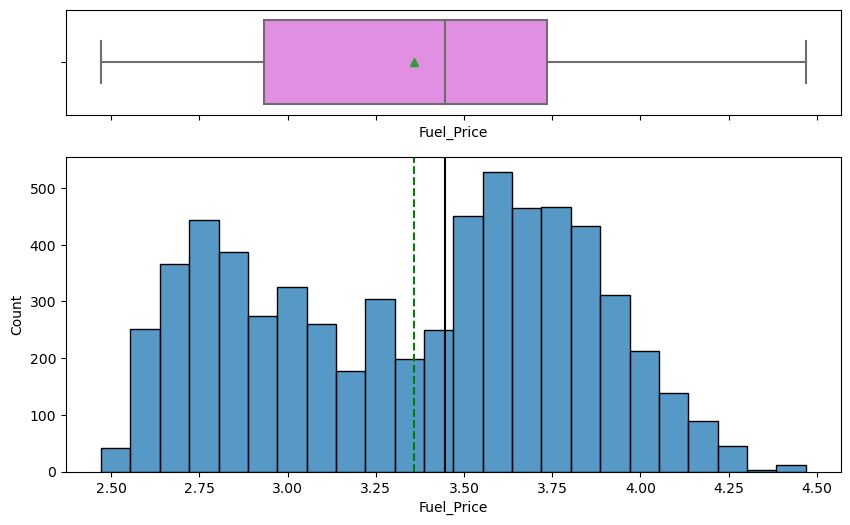

In [26]:
histogram_boxplot(df2,"Fuel_Price")

* While our observation of skewness stated a mildly negative skew, the graph indicates a " head and shoulder" double peak. This would indicate volatility and not necessarily a normal distribution. I would suggest that this is due to the market conditions of oil prices. This is rooted in the low responsiveness or inelasticity of supply and demand and a reflection of the significant manipulation of oil prices by the Organization of the Petroleum Exporting Countries ( OPEC). 
* Fuel_Price- - .096158 very mild negative skew- almost symmetric but a slightly longer left tail

 <img src="oilchart.png" width="400" height="200">

* OPEC was established at a conference held in Baghdad September 10–14, 1960, and was formally constituted in January 1961 by five countries: Saudi Arabia. Iran. Iraq.
* In 1973 ( October ) a oil embargo temporarily stopped oil shipments from the Middle East to the United States, The Netherlands, Portugal, Rhodesia and South Africa in retaliation for support for Israel during the Yom Kippur War.- Source: Brittanica.com

### CPI- consumer price index

* CPI is the measure of the average change in prices over time for a market basket of consumer goods and services. Its widely used as a measure for inflation and is followed closely by the media, policymakers, financial markets businesses and consumers. 

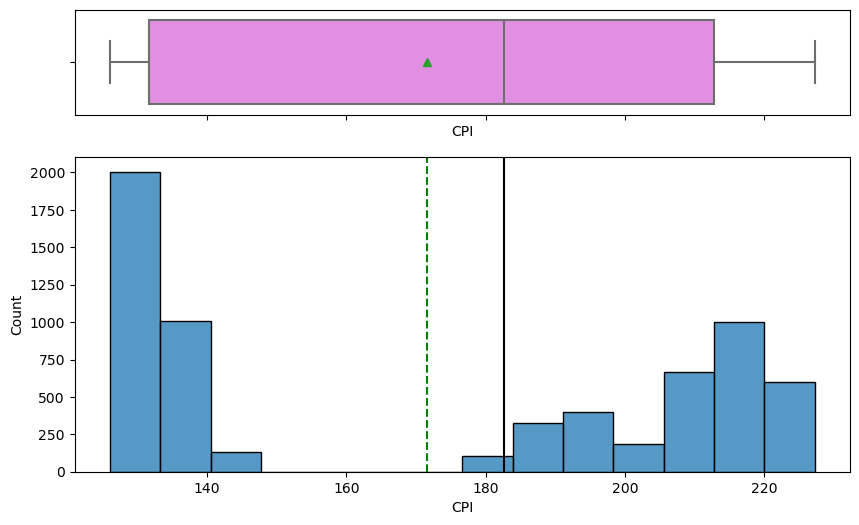

In [27]:
histogram_boxplot(df2,"CPI")

* Similar to Fuel_Price, our purely numeric assumption based upon skewness would not be correct. This shows volatility where one peak is significantly higher than the other.

### Unemployment

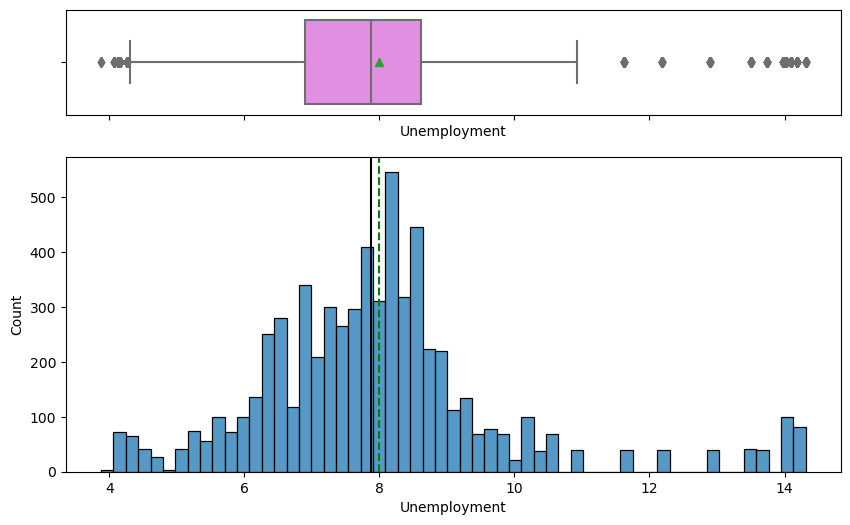

In [28]:
histogram_boxplot(df2,"Unemployment")

* Generally this seems to be consistant with the calculation and observation made earlier ( below )
* Unemployment- 1.188144 Mild postive skew- longer tail on the right indicating that some higher values that pull the mean to the right of the median. 

### Bivariate Analysis

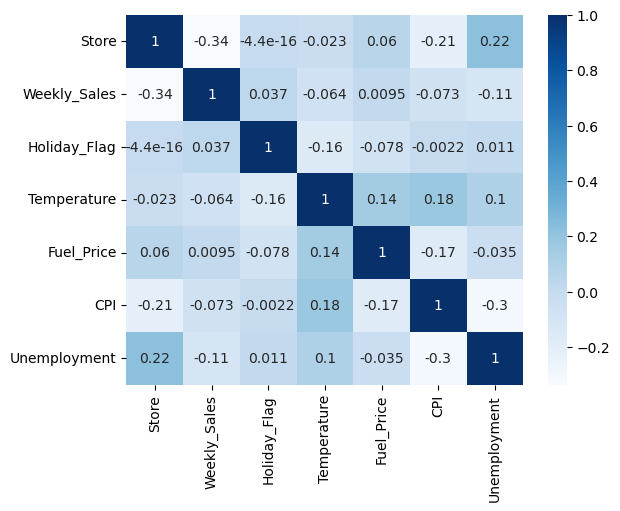

In [29]:
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.show()

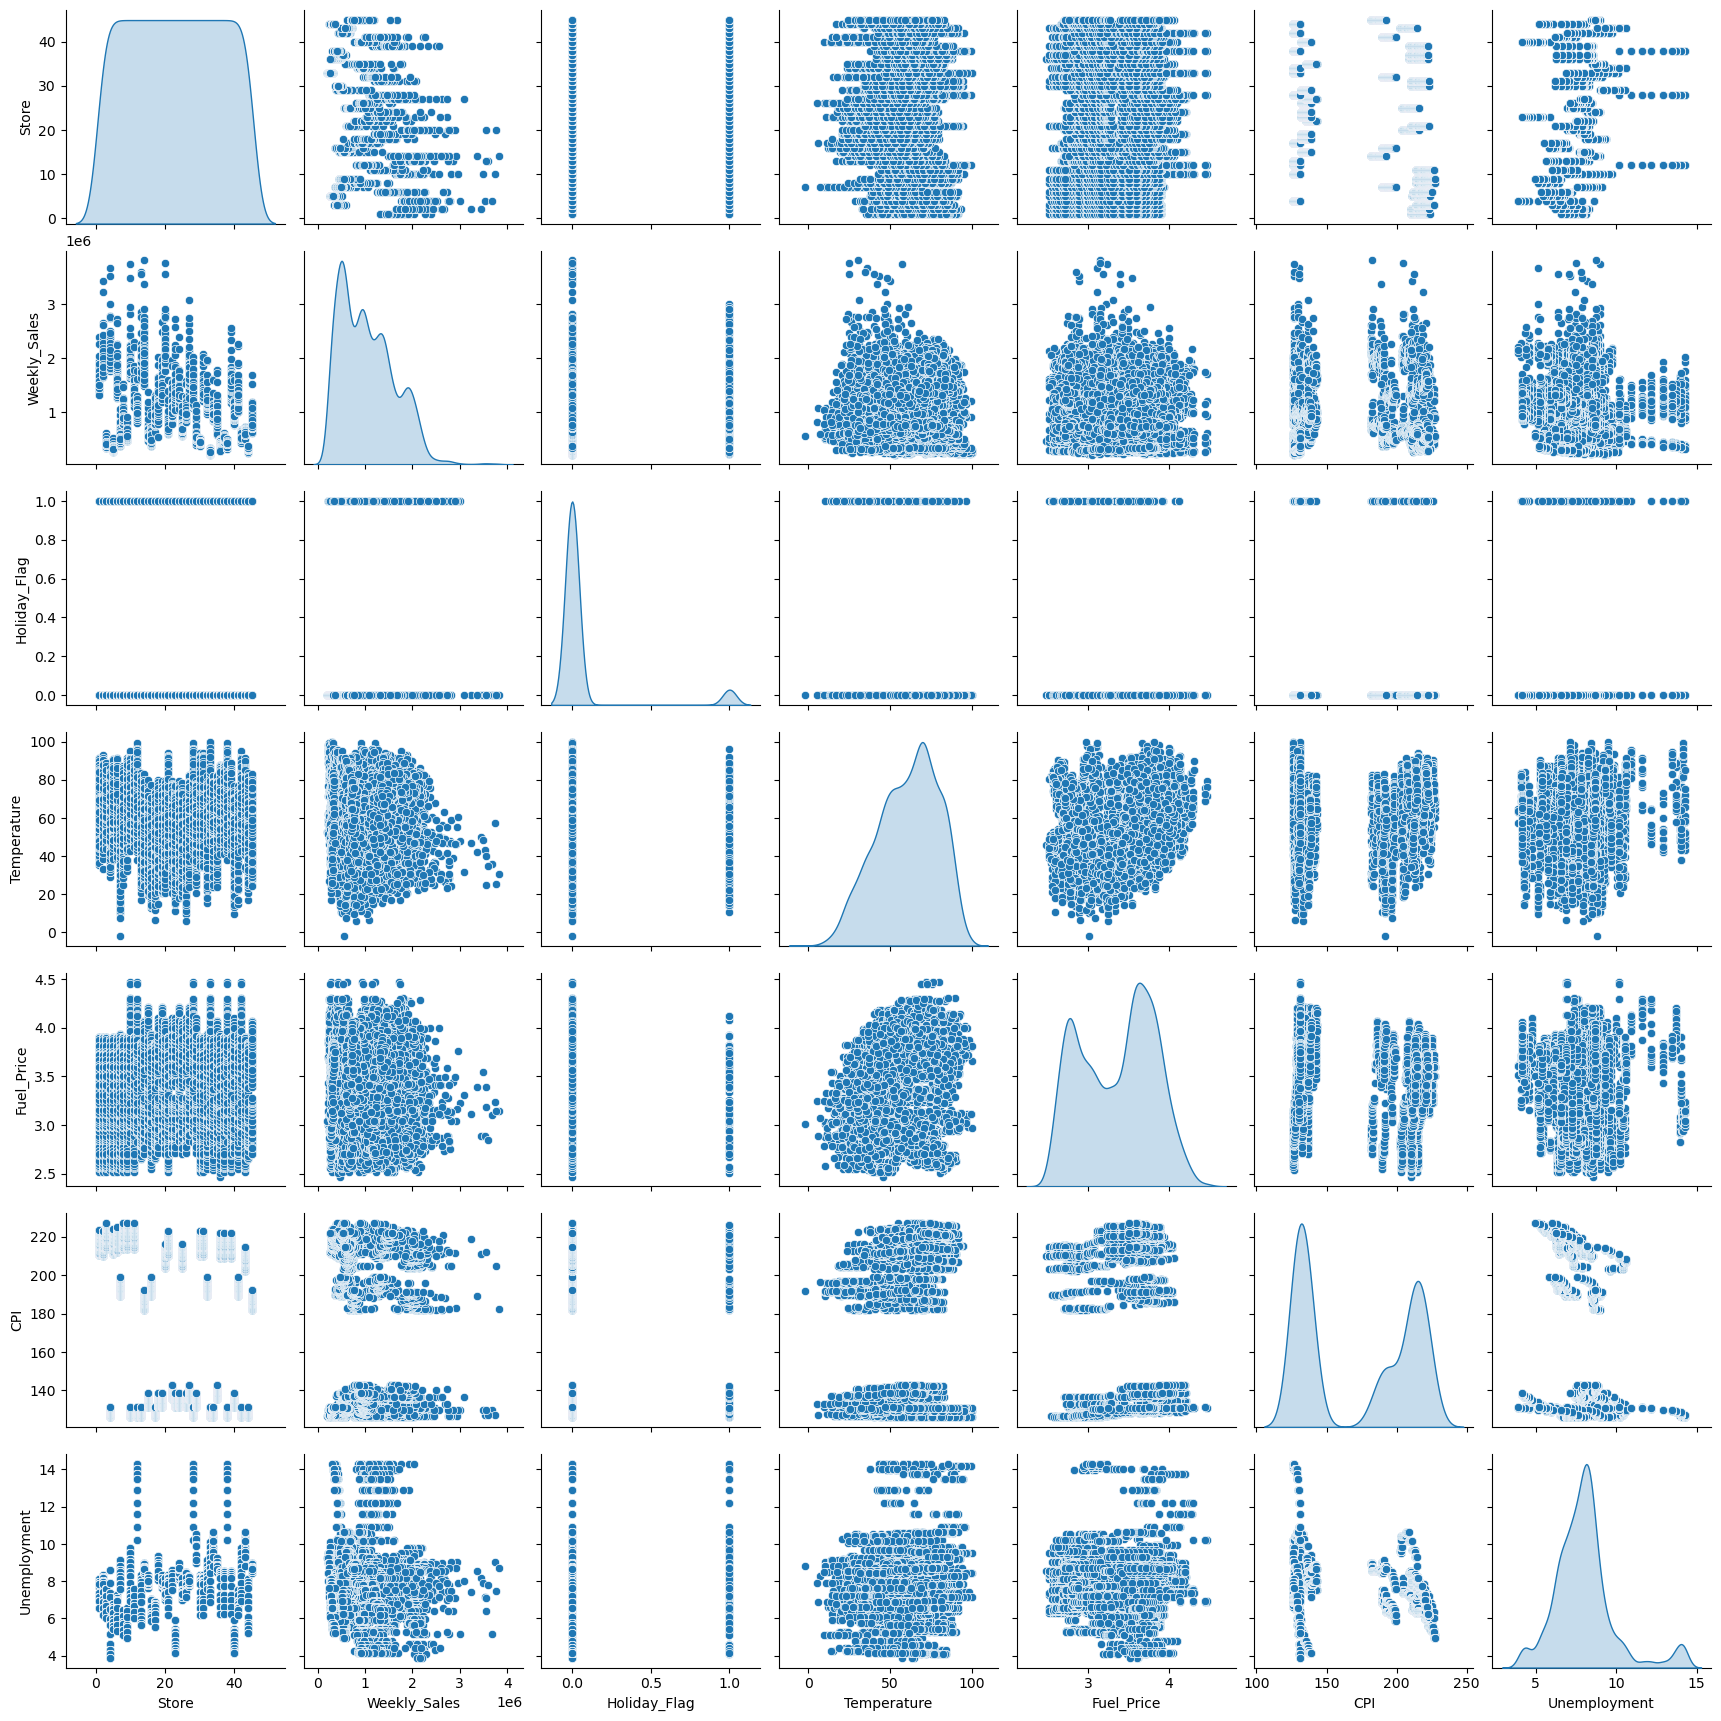

In [30]:
sns.pairplot(df, diag_kind='kde')
plt.show()


### Weekly Sales versus Unemployment rate ( to help to answer 1(a))

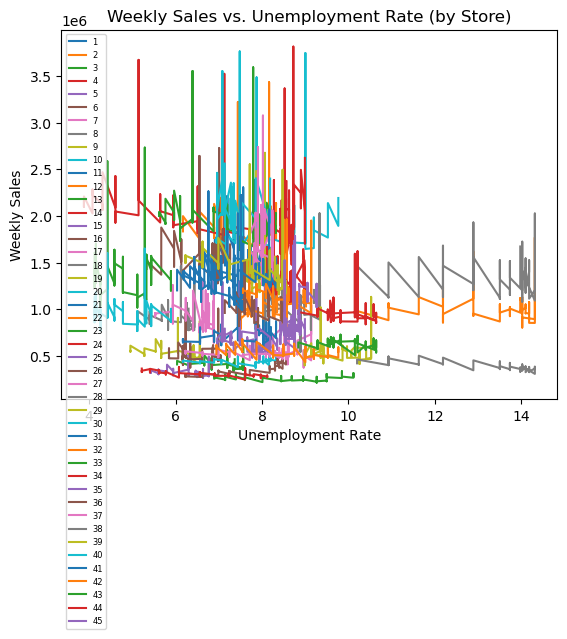

In [31]:
# Group data by "Store"
grouped_data = df2.groupby("Store")[["Weekly_Sales", "Unemployment"]]

# Plot line for each store
for store_name, store_data in grouped_data:
    plt.plot(store_data["Unemployment"], store_data["Weekly_Sales"], label=store_name)

# Add labels and title
plt.xlabel("Unemployment Rate")
plt.ylabel("Weekly Sales")
plt.title("Weekly Sales vs. Unemployment Rate (by Store)")

# Add legend
plt.legend(loc="best", fontsize=6)

# Show the plot
plt.show()


* a lot going on with that chart which makes it difficult to get real insights , so we will dive deeper

<a id='1a.'></a>

<h2 style ="color:RED;"> 1a.</h2>

<h2 style ="color:RED;"> 1a. Question: If the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most? </h2>

* initially we look at the correlation matrix and would quickly state that there doesn't appear to be a strong correlation since weekly sales is -.11 correlated to unemployment. However when we also look and see that the store indicates a .22 correlation we may want to dig deeper to see if there are dimensions that we may be missing to properly answer this question.  

In [32]:
# we are going to isolate and correlate only stores, Weekly_Sales and Unemployment
correlations = df2.groupby("Store")[["Weekly_Sales", "Unemployment"]].corr()

In [33]:
# Access the correlations using the correct MultiIndex structure:
store_correlations = correlations["Weekly_Sales"].loc[:, "Unemployment"]

In [34]:
# Print the correlations for each store
print("Correlation between weekly sales and unemployment rate:\n", store_correlations)

Correlation between weekly sales and unemployment rate:
 Store
1    -0.097955
2     0.066325
3    -0.230413
4    -0.337015
5    -0.207043
6     0.044251
7    -0.165382
8    -0.052580
9    -0.191534
10    0.131908
11   -0.020339
12   -0.009286
13   -0.171633
14    0.210786
15    0.078905
16   -0.070864
17   -0.263600
18    0.139179
19    0.101464
20   -0.095341
21    0.218367
22    0.039043
23   -0.077169
24   -0.012261
25   -0.004958
26   -0.066899
27   -0.014275
28    0.136671
29    0.084682
30    0.201862
31   -0.064738
32   -0.099455
33    0.101175
34    0.017010
35    0.483865
36    0.833734
37   -0.221287
38   -0.785290
39   -0.384681
40   -0.112528
41   -0.350630
42   -0.356355
43   -0.201954
44   -0.780076
45   -0.004041
Name: Weekly_Sales, dtype: float64


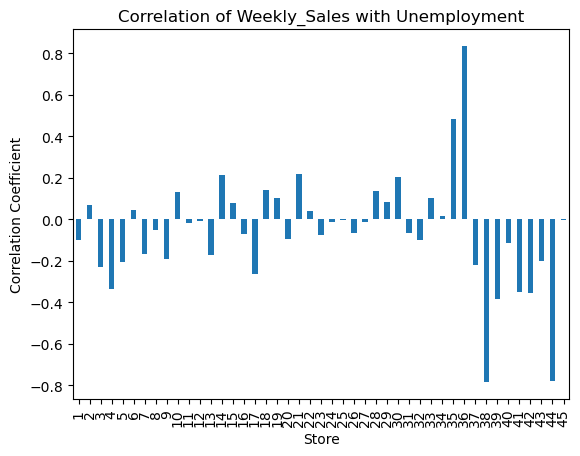

In [35]:
# Visualize the correlations using a bar chart
store_correlations.plot(kind="bar")
plt.xlabel("Store")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation of Weekly_Sales with Unemployment")
plt.show()

* we can see that there are stores that are severely impacted by unemployment. Some stores are positively impacted while more stores are negatively impacted.

In [36]:
# Identify stores with the strongest negative correlations
most_affected_stores = store_correlations.sort_values(ascending=True).head(29)  # only stores negatively affected selected
print("\nStores most affected by unemployment:\n", most_affected_stores)



Stores most affected by unemployment:
 Store
38   -0.785290
44   -0.780076
39   -0.384681
42   -0.356355
41   -0.350630
4    -0.337015
17   -0.263600
3    -0.230413
37   -0.221287
5    -0.207043
43   -0.201954
9    -0.191534
13   -0.171633
7    -0.165382
40   -0.112528
32   -0.099455
1    -0.097955
20   -0.095341
23   -0.077169
16   -0.070864
26   -0.066899
31   -0.064738
8    -0.052580
11   -0.020339
27   -0.014275
24   -0.012261
12   -0.009286
25   -0.004958
45   -0.004041
Name: Weekly_Sales, dtype: float64


In [37]:
# Get the number of stores with negative correlations:
num_negative_correlated_stores = (store_correlations < 0).sum()
# Get the number of stores with positive correlations: 
positive_correlation_stores = (store_correlations >= 0).sum()
# Calculate the percentage of stores with negative correlations:
percentage_negative_correlated = (num_negative_correlated_stores / len(store_correlations)) * 100
# Calculate the percentage of stores with negative correlations:
percentage_positive_correlated = (positive_correlation_stores / len(store_correlations)) * 100
# Print the percentage:
print(f"Percentage of stores with positive correlations:{percentage_positive_correlated:.2f}%")
print(f"Percentage of stores with negative correlations:{percentage_negative_correlated:.2f}%")

Percentage of stores with positive correlations:35.56%
Percentage of stores with negative correlations:64.44%


In [38]:
# Get the aligned `store_correlations`
store_correlations = store_correlations.reset_index()

# Initialize variables
total_weekly_sales = df2["Weekly_Sales"].sum()
negatively_correlated_sales = 0

# Loop through each store
for index, row in store_correlations.iterrows():
    store_id = row["Store"]
    correlation = row["Weekly_Sales"]
    
    # Check if negatively correlated
    if correlation < 0:
        negatively_correlated_sales += df2[df2["Store"] == store_id]["Weekly_Sales"].sum()

# Calculate and format percentage
if negatively_correlated_sales > 0:
    percentage_affected = (negatively_correlated_sales / total_weekly_sales) * 100
    print(f"Percentage of total sales affected by negatively correlated stores: {percentage_affected:.2f}%")
    print(f"Total Sales affected by a negative correlation to Unemployment: ${negatively_correlated_sales:.2f}")
else:
    print("No stores have negative correlations with unemployment.")


Percentage of total sales affected by negatively correlated stores: 63.56%
Total Sales affected by a negative correlation to Unemployment: $4281920990.52


<h2 style ="color:RED;"> 1a. ANSWER BELOW:</h2>

* 64.44% of the stores are negatively affected by unemployment (29 of the 45 stores). The percentage of sales affected comes to 63.56% of sales and the total sales affected by unemployment is $4,281,920,990.52. We can therefore say with confidence that unemployment has a negative impact on the sales of the stores at Walmart

<h2 style ="color:RED;"> 1b.Question: If the weekly sales show a seasonal trend, when and what could be the reason?
 </h2>

In [39]:
# Checking the stationarity of the data

result = adfuller(df2['Weekly_Sales'])
p_value = result[1]
print(p_value)
if p_value < 0.05:
    print("The time series is stationary")
else:
    print("The time series is non-stationary")
    

0.00011655869699901207
The time series is stationary


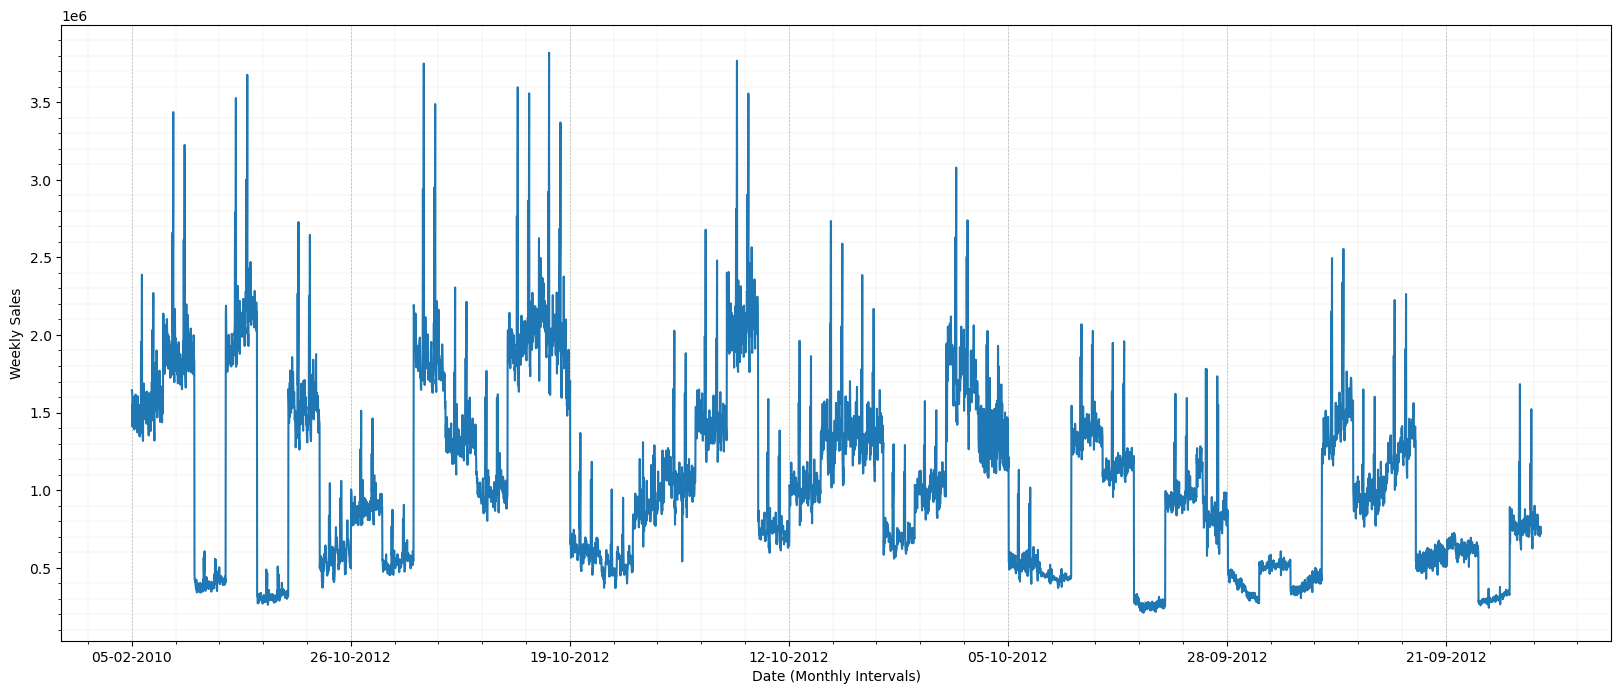

In [40]:

# Create the plot
plt.figure(figsize=(20, 8))
df['Weekly_Sales'].plot()

# Set major gridlines for monthly intervals
plt.gca().xaxis.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.minorticks_on()  # Enable minor ticks for weekly intervals
plt.grid(which='minor', linestyle=':', linewidth=0.25)

# Customize labels for better readability
plt.xlabel('Date (Monthly Intervals)')
plt.ylabel('Weekly Sales')

# Set monthly labels for major gridlines if 'Date' column is present
if 'Date' in df.columns:
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))  #


* the data shows a clear seasonality of Weekly_Sales

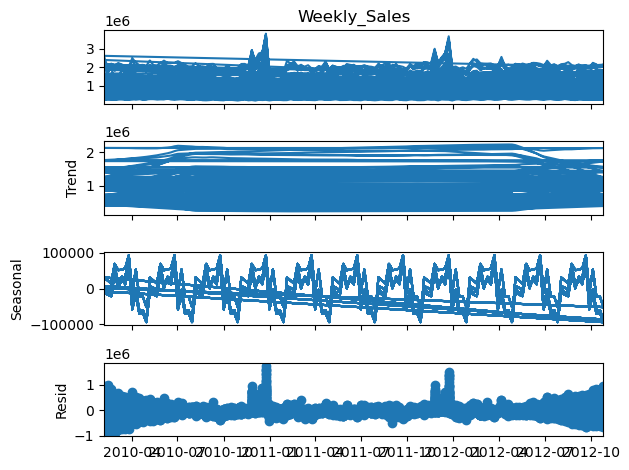

In [41]:
# Decomposition to separate sales data into trend, seasonal and residual components for further analysis 
# Convert 'Date' index to datetime
df.index = pd.to_datetime(df.index, format='%d-%m-%Y')

# Decompose the time series
result = seasonal_decompose(df['Weekly_Sales'], model='additive', period=52)  # Assuming weekly data

# Plotting the decomposed time series components
result.plot()
plt.show()


* The trend line appears to be fairly flat with some slight variations.
* Seasonal - there does seem to be a regular pattern of variability in the sales data ( holiday periods and off peak seasonality)
* Residual component- residuals are the component that is left over after the trend and seasonal components have been removed from the data
- there seems to be a few fluctuationssuggesting there may be additional patterns that the model has not captured

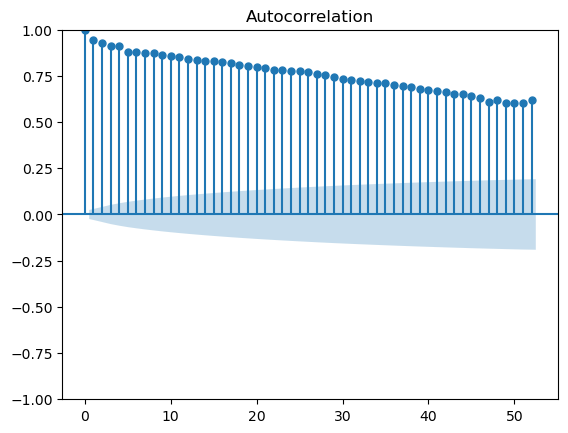

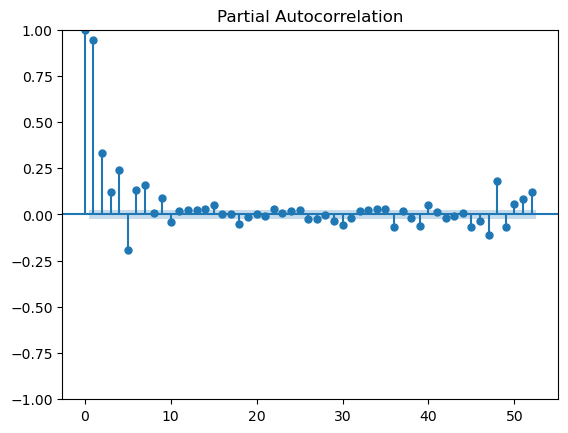

In [42]:
# Autocorrelation and partial autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Weekly_Sales'], lags=52)  # lags can be set according to your data frequency
plot_pacf(df['Weekly_Sales'], lags=52)
plt.show()


* insights from Autocorrelation: 
    - as the lag increases there is a gradual decrease in the autocorrelation which would indicate that weekly sales are less correlated with their own past values as time goes by. 
    - There is a slow decay of the autocorrelation - indicating that this is a non-stationary time series showing a strong trend - ie. a seasonal component. 
    - autocorrelation remains positive for many lag periods once again reflecting on the seasonality of the data. ( weekly patterns) 
    - Holidays , back to school and other cyclical events may have a expression here. 
    
* insights from Partial Autocorrelation
    - the Partial Autocorrelation plot does not show a lot of seasonality- which is surprising . The immediate periods show a more immediate impact in prediction than the seasonality. 


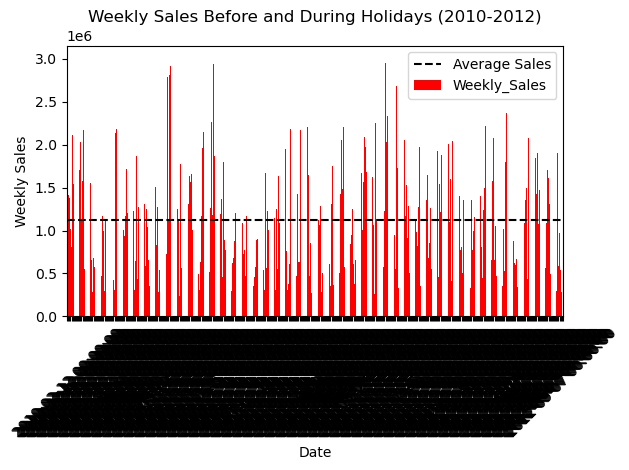

In [43]:
# Filter for holiday weeks and the week before holidays
holiday_weeks = df[df['Holiday_Flag'] == 1]
week_before_holiday = holiday_weeks.shift(1)
# Combine the two DataFrames
combined_holidays = pd.concat([holiday_weeks, week_before_holiday]).drop_duplicates().sort_index()

# Calculate the average weekly sales
average_sales = combined_holidays['Weekly_Sales'].mean()

# Plot the bar chart
combined_holidays['Weekly_Sales'].plot(kind='bar', color= 'red' , title='Weekly Sales Before and During Holidays (2010-2012)')

# Add the average sales line
plt.axhline(y=average_sales, color='black', linestyle='--', label='Average Sales')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()
plt.legend()  # Add legend to show the average sales line
plt.show()

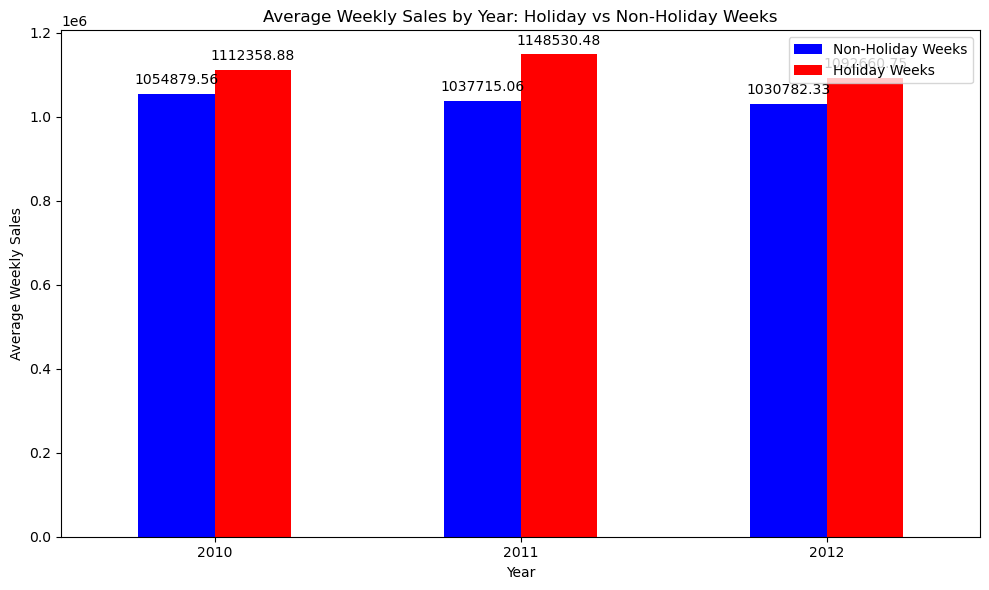

In [44]:
# Group the data by year and holiday flag, then calculate the mean weekly sales
weekly_sales_by_year_holiday = df.groupby([df.index.year, 'Holiday_Flag'])['Weekly_Sales'].mean().unstack()

# Plot the results with annotations
ax = weekly_sales_by_year_holiday.plot(kind='bar', figsize=(10, 6), color=['blue', 'red'])
plt.title('Average Weekly Sales by Year: Holiday vs Non-Holiday Weeks')
plt.xlabel('Year')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal for readability
plt.legend(['Non-Holiday Weeks', 'Holiday Weeks'])
plt.tight_layout()

# Annotate the bars with the percentage of sales
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [45]:
df3 = df.copy()


<Figure size 800x400 with 0 Axes>

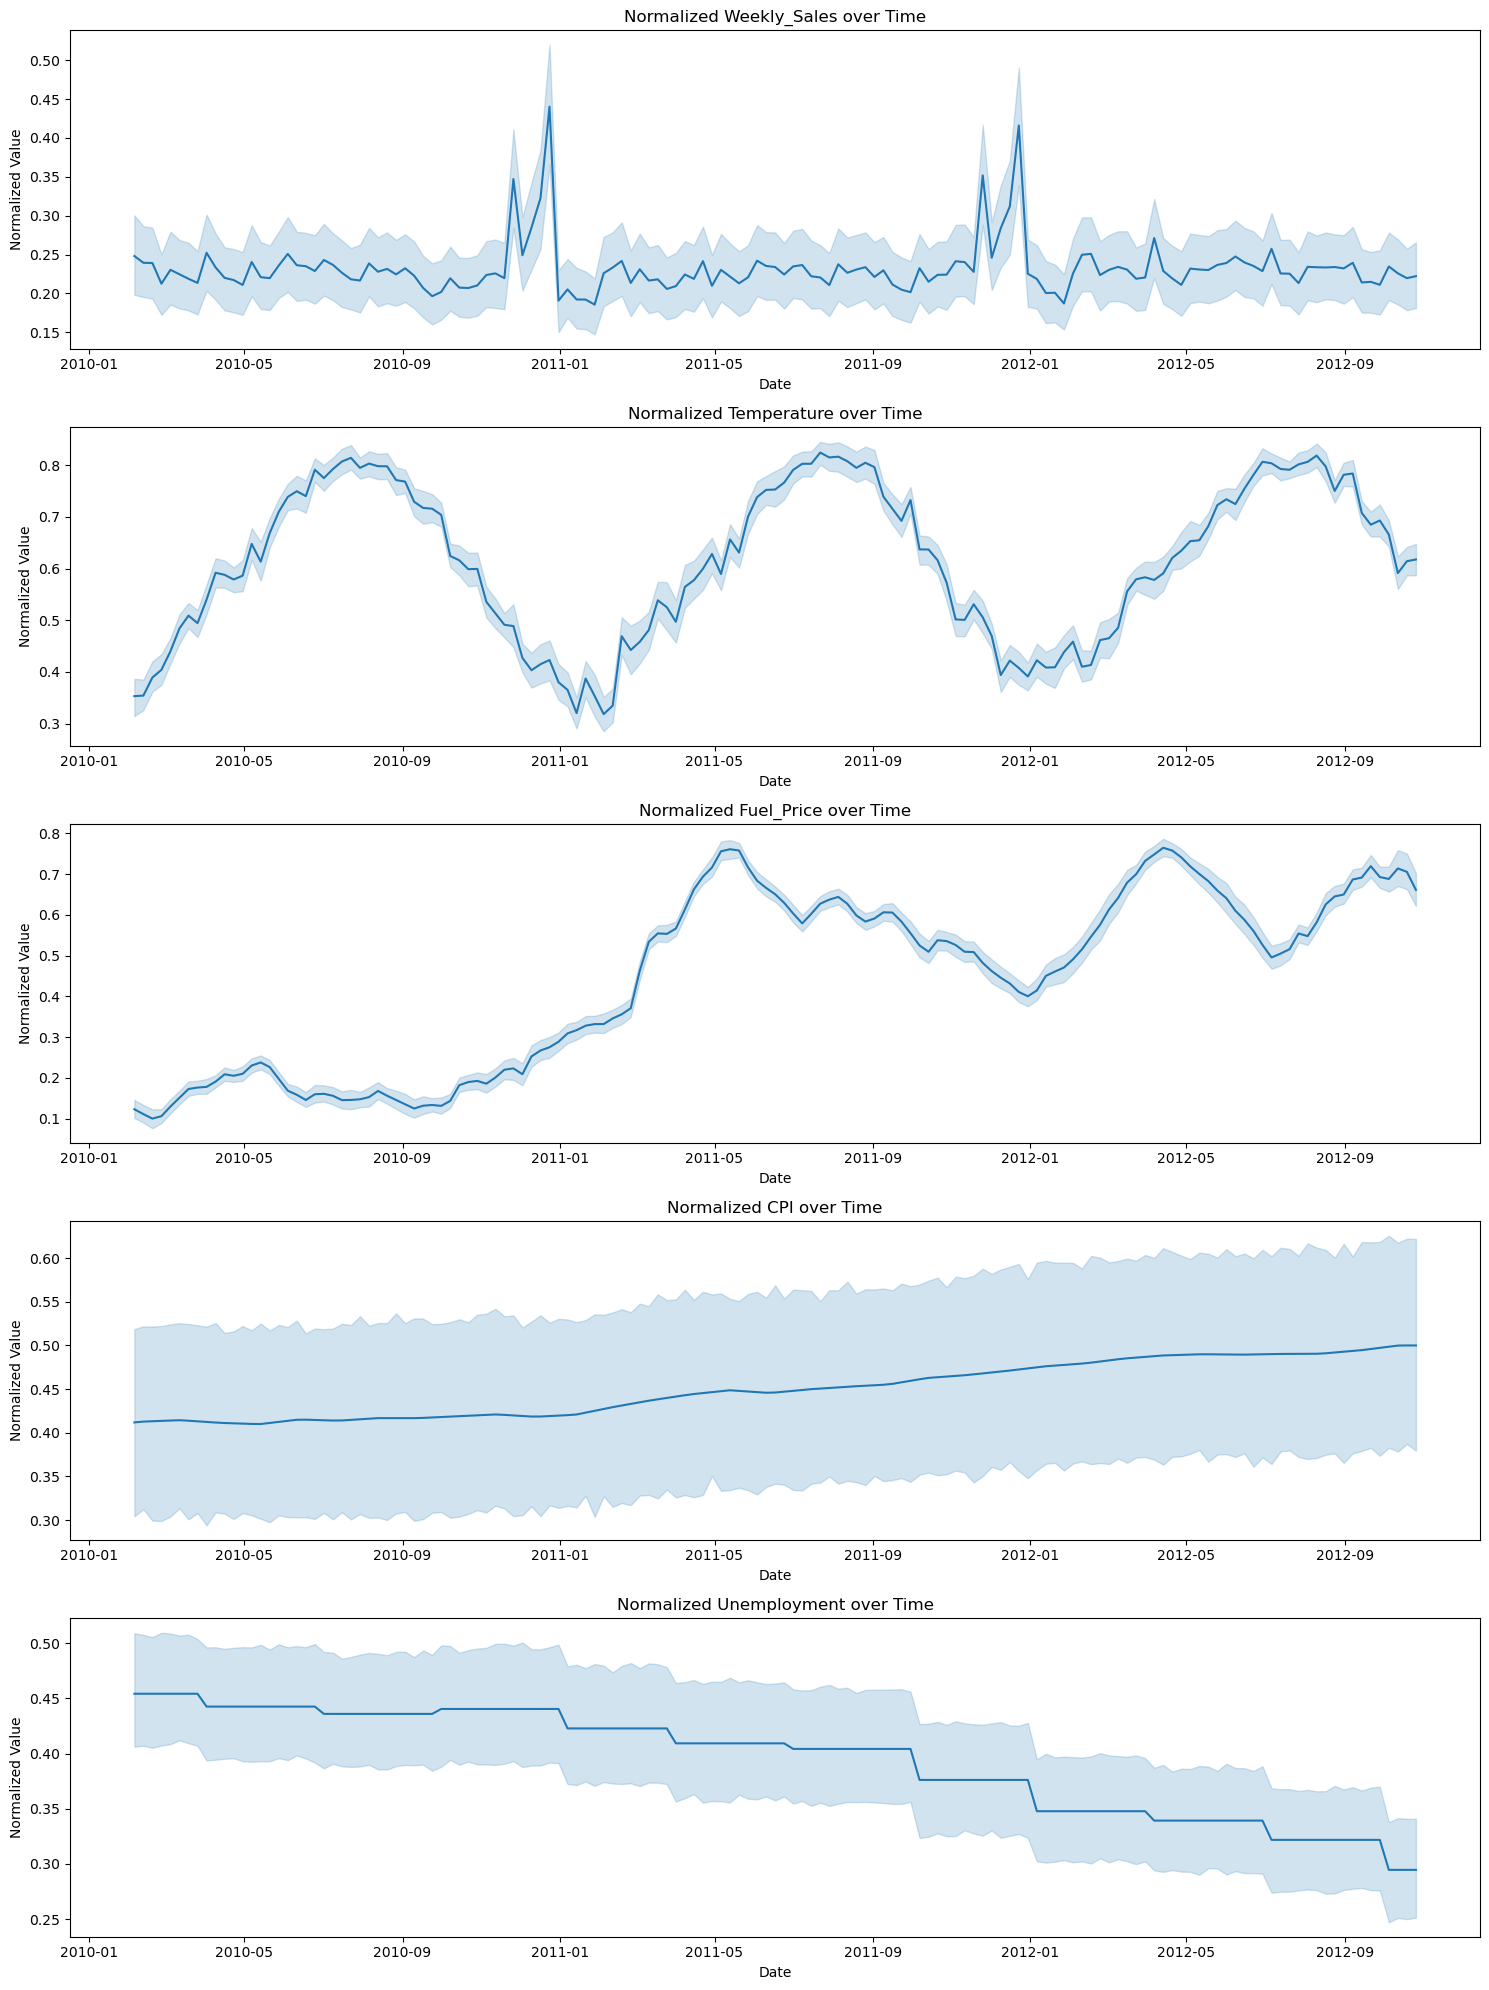

In [46]:
# Define the columns to normalize
columns_to_normalize = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the specified columns
df3[columns_to_normalize] = scaler.fit_transform(df3[columns_to_normalize])

# Plot each of the normalized columns
plt.figure(figsize=(8, 4))
fig, ax = plt.subplots(len(columns_to_normalize), 1, figsize=(15, 20))

for i, col in enumerate(columns_to_normalize):
    sns.lineplot(data=df3, x=df3.index, y=col, ax=ax[i])
    ax[i].set_title(f'Normalized {col} over Time')
    ax[i].set_ylabel('Normalized Value')

plt.tight_layout()
plt.show()


In [47]:
correlation = df["Weekly_Sales"].corr(df["Holiday_Flag"])
print(f"Correlation between Weekly_Sales and Holiday_Flag: {correlation:.3f}")

Correlation between Weekly_Sales and Holiday_Flag: 0.037


<h2 style ="color:RED;"> 1b. ANSWER BELOW:</h2>

* the weekly sales does show a seasonal trend as we described in the graph using autocorrelation. However as we displayed, the predictive nature of the week is less prolific than the previous week. From the Correlation matrix we know the following relationships from positive to negative:
    -Positive-  Holiday ( .037), Fuel_Price(.0095)
    -Negative- Temperature(-.064), CPI(-.073), Unemployment-.11)
    
* evaluating the average sales numbers of Weekly_Sales of Holiday weeks versus non-Holiday weeks we see a 7.3797% difference overall. Further as displayed by the normalized graph, clearly the most pronounced are Thanksgiving and Christmas Holidays. 
* The seasonal trend will occur during the season of Thanksgiving and Christmas most pronounced. ( starting November and Ending in January) 

<h2 style ="color:RED;"> 1c.Question: Does temperature affect the weekly sales in any manner??
 </h2>

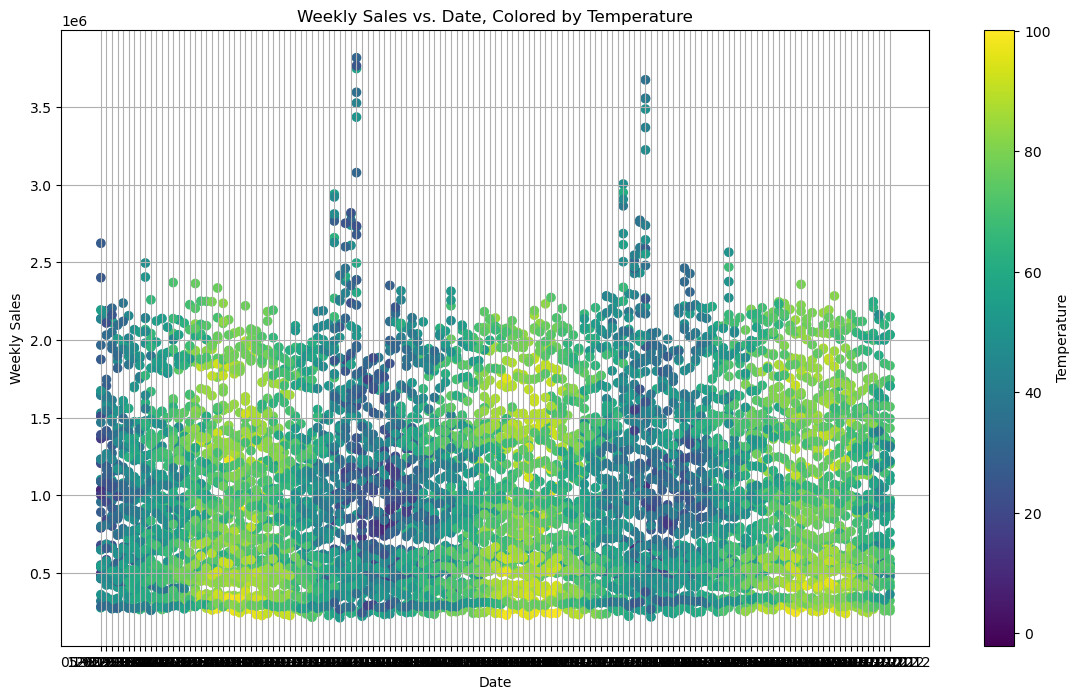

In [48]:
# Graph of Weekly_Sales and Temperature
plt.figure(figsize=(14, 8))  # Set figure size
# Create the scatter plot
plt.scatter(df2["Date"], df2["Weekly_Sales"], c=df2["Temperature"])
plt.grid()
plt.colorbar(label="Temperature")

# Add labels and title
plt.xlabel("Date")  # Label for the x-axis
plt.ylabel("Weekly Sales")  # Label for the y-axis
plt.title("Weekly Sales vs. Date, Colored by Temperature")  # Overall plot title

plt.show()

In [49]:
correlation = df2["Weekly_Sales"].corr(df2["Temperature"])
print(f"Correlation between Weekly_Sales and Temperature: {correlation:.2f}")

Correlation between Weekly_Sales and Temperature: -0.06


* There appears to be a slightly negative impact on sales as the temperature rises. The relationship is weak and may not be statistically important except when the average temperature becomes extreme 

In [50]:
# Create bins with 4-degree intervals (adjust if needed)
bins = range(int(df2["Temperature"].min()), int(df2["Temperature"].max()) + 5, 4)
bin_labels = [f"{bin_start}-{bin_start+3}" for bin_start in bins[:-1]]

In [51]:
# Group data by bins and calculate correlations, p-values, and significance
# setting the p-value to .05 which must be exceeded to reject the null hypothesis 
tempcorrs = {}
pvalues = {}
significance = {}  # Dictionary to store significance decisions
for bin_label, temp_data in df2.groupby(pd.cut(df2["Temperature"], bins=bins, labels=bin_labels)):
    if len(temp_data) >= 2:  # Check for sufficient data points
        tempcorr, pvalue = stats.pearsonr(temp_data["Weekly_Sales"], temp_data["Temperature"])
        tempcorrs[bin_label] = round(tempcorr, 3)
        pvalues[bin_label] = round(pvalue, 3)
        significance[bin_label] = "Reject H0" if pvalue < 0.05 else "Fail to Reject H0"
    else:
        print(f"Skipping {bin_label} due to insufficient data points.")


Skipping -2-1 due to insufficient data points.
Skipping 2-5 due to insufficient data points.


In [52]:
# Print results in a table
print("Temperature Range | Correlation | p-value | Significance")
print("-------------------|-------------|---------|------------------")
for bin_label in bin_labels:
    if bin_label in tempcorrs:
        print(f"{bin_label:>16} | {tempcorrs[bin_label]:.3f}   | {pvalues[bin_label]:.3e} | {significance[bin_label]}")
    else:
        print(f"{bin_label:>16} | No results (insufficient data)")

Temperature Range | Correlation | p-value | Significance
-------------------|-------------|---------|------------------
            -2-1 | No results (insufficient data)
             2-5 | No results (insufficient data)
             6-9 | -0.105   | 8.950e-01 | Fail to Reject H0
           10-13 | 0.170   | 5.440e-01 | Fail to Reject H0
           14-17 | 0.097   | 5.660e-01 | Fail to Reject H0
           18-21 | 0.078   | 5.080e-01 | Fail to Reject H0
           22-25 | 0.105   | 2.380e-01 | Fail to Reject H0
           26-29 | 0.013   | 8.780e-01 | Fail to Reject H0
           30-33 | -0.019   | 7.920e-01 | Fail to Reject H0
           34-37 | 0.017   | 7.850e-01 | Fail to Reject H0
           38-41 | 0.033   | 5.960e-01 | Fail to Reject H0
           42-45 | -0.086   | 1.130e-01 | Fail to Reject H0
           46-49 | -0.053   | 3.010e-01 | Fail to Reject H0
           50-53 | -0.003   | 9.550e-01 | Fail to Reject H0
           54-57 | -0.021   | 6.600e-01 | Fail to Reject H0
       

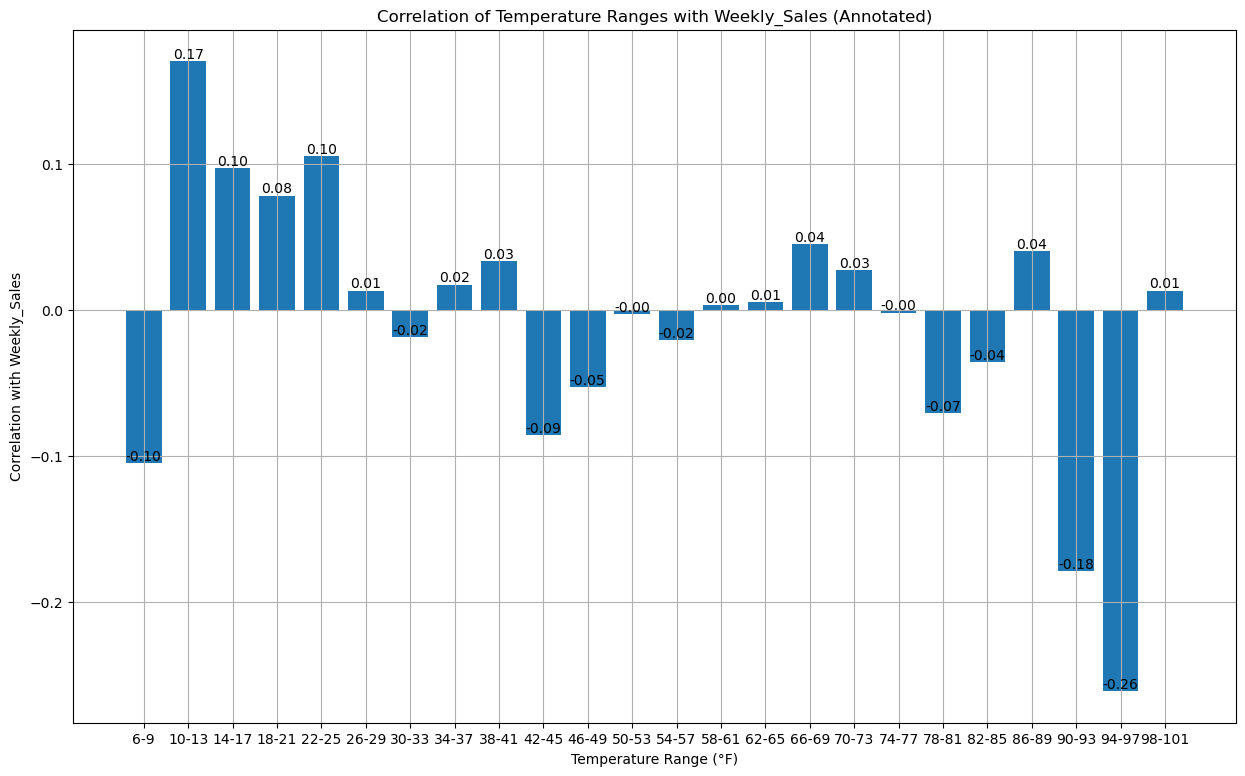

In [53]:

# Create the bar chart with annotations
plt.figure(figsize=(15, 9))
plt.bar(tempcorrs.keys(), tempcorrs.values())

# Add annotations above each bar
for i, (bin_label, tempcorr) in enumerate(tempcorrs.items()):
    plt.annotate(f"{tempcorr:.2f}",  # Round correlation to 2 decimals
                  xy=(i, tempcorr),  # Position above the bar
                  ha="center",  # Horizontally center the annotation
                  va="bottom",  # Vertical alignment at the bottom of the text
                  fontsize=10)  # Adjust font size as needed

plt.xlabel("Temperature Range (°F)")
plt.ylabel("Correlation with Weekly_Sales")
plt.title("Correlation of Temperature Ranges with Weekly_Sales (Annotated)")
plt.grid(True)
plt.show()


<h2 style ="color:RED;"> 1c. ANSWER BELOW:</h2>

* Initially it was observated " Correlation between Weekly_Sales and Temperature: -0.06", which would provide a inference of a weak coorelation. However after graphing and evaluation was done , additional insights seemed possible or even plausible.
* Since the question is "Does temperature affect the weekly sales in any manner", then strictly speaking I have provided statistical evidence that it does, however it is situational. Generally there is a weak relationship between Weekly_Sales and Temperature, unless the temperatures operate in the extremes. 

* During my analysis, I used a bin technique to group the temperatures together to then ran a statistical test using the standard p-value for significance (.05) as a test to either accept or reject the null hypothesis. One bin 90-93 received a "Reject the Hypothesis" evaluation. 

* Recommendation : To the store manager- when the temperature reaches 
-- below 10 degrees, expect a potential negative impact on your sales
-- from 10 to 26 degrees there may be a slight improvement of sales
-- above 89 degrees to 97 you may experience a negative impact on sales.

<h2 style ="color:RED;"> 1d. QUESTION: How is the Consumer Price Index ( CPI ) affecting the weekly sales in various stores?:</h2>

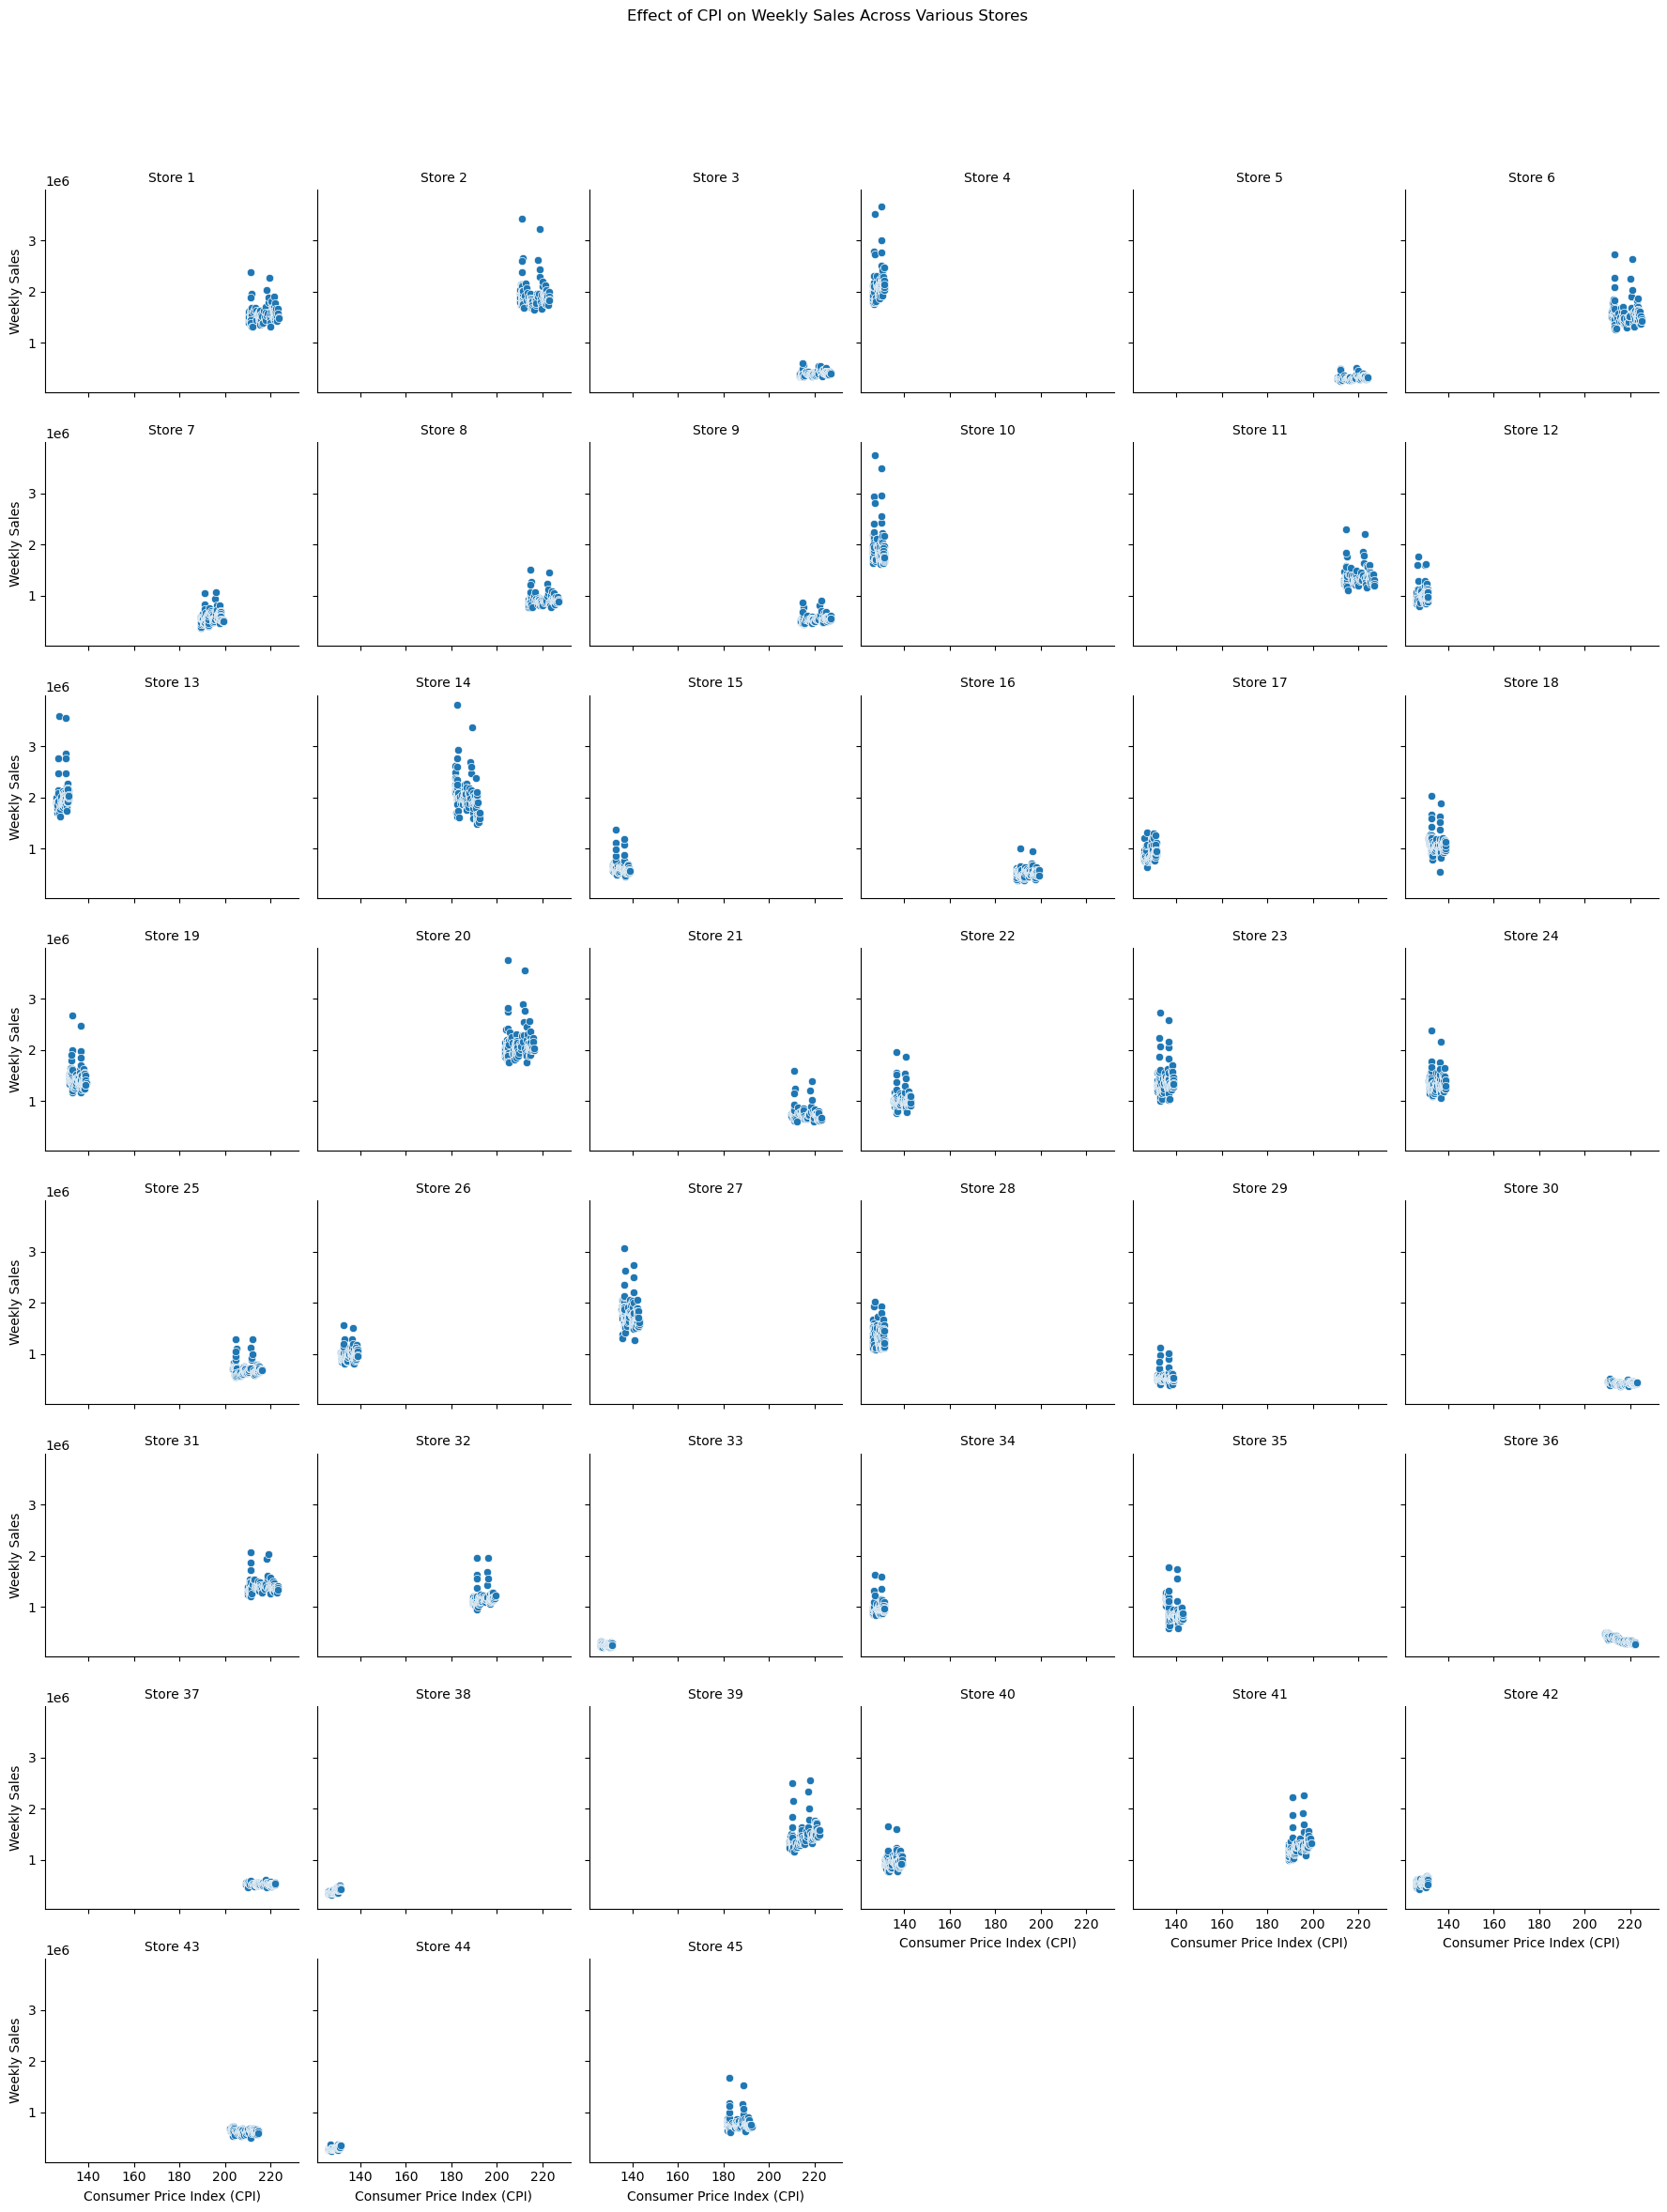

In [54]:

# Create a FacetGrid to make individual scatter plots for each store
g = sns.FacetGrid(df, col="Store", col_wrap=6, height=3)
g = g.map(sns.scatterplot, "CPI", "Weekly_Sales")

# Add titles and labels
g.set_titles('Store {col_name}')
g.set_axis_labels('Consumer Price Index (CPI)', 'Weekly Sales')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Effect of CPI on Weekly Sales Across Various Stores')

# Show plot
plt.show()


In [55]:
# using scaled data from df3 from previously
# Calculate the variance of Weekly Sales grouped by Store and CPI
# Since variance is sensitive to the scale of CPI, we might need to group CPI into categories.
# For simplicity, let's assume we're looking at the variance of sales at different CPI levels for each store.

# First, categorize the CPI into quantiles for better grouping
df['CPI_Category'] = pd.qcut(df['CPI'], q=10, labels=False)

# Group by 'Store' and 'CPI_Category' and then calculate variance
variance_by_store_cpi = df.groupby(['Store', 'CPI_Category'])['Weekly_Sales'].var().reset_index()

# Now, calculate the average variance for each store across CPI categories
average_variance_by_store = variance_by_store_cpi.groupby('Store')['Weekly_Sales'].mean().sort_values()

# Print the stores by ascending order of their variance to CPI
average_variance_by_store


Store
44    2.768026e+08
30    3.338820e+08
37    4.643215e+08
33    5.158424e+08
36    5.514682e+08
38    8.202034e+08
43    1.229440e+09
5     1.288700e+09
3     1.705937e+09
42    2.306737e+09
9     3.391130e+09
16    5.861382e+09
29    9.219262e+09
34    9.219943e+09
8     9.561493e+09
17    1.044428e+10
7     1.098277e+10
25    1.125416e+10
26    1.162156e+10
15    1.290279e+10
21    1.297823e+10
31    1.320834e+10
32    1.324987e+10
40    1.358520e+10
12    1.663437e+10
1     2.039020e+10
45    2.126753e+10
11    2.364996e+10
41    2.440343e+10
18    2.569546e+10
24    2.648284e+10
22    2.825255e+10
28    2.901500e+10
19    3.277263e+10
35    3.998690e+10
6     4.104749e+10
39    4.134994e+10
2     4.855512e+10
4     5.468955e+10
13    5.811568e+10
23    5.912567e+10
27    6.068564e+10
20    6.347143e+10
10    7.458927e+10
14    9.868624e+10
Name: Weekly_Sales, dtype: float64

In [56]:
# Calculate the correlation coefficient between CPI and Weekly Sales for each store
correlation_by_store = df.groupby('Store').apply(lambda x: x['CPI'].corr(x['Weekly_Sales']))

# Print the correlation coefficients for each store
print(correlation_by_store.sort_values())


Store
36   -0.915095
35   -0.424107
14   -0.419755
30   -0.298188
43   -0.285686
27   -0.213082
18   -0.193541
15   -0.174467
21   -0.163649
19   -0.155341
10   -0.115374
28   -0.095908
29   -0.072530
2    -0.062431
33   -0.052271
22   -0.038602
45   -0.023548
24   -0.013684
6    -0.011357
25   -0.010914
20    0.058706
11    0.069781
12    0.084087
23    0.084248
40    0.113318
34    0.115437
8     0.120255
16    0.124285
26    0.131980
31    0.132887
13    0.163976
32    0.196782
1     0.225408
37    0.244507
7     0.289044
9     0.294805
5     0.308261
3     0.317250
17    0.348571
4     0.351157
42    0.360859
41    0.392293
39    0.428043
44    0.740150
38    0.812837
dtype: float64


<h2 style ="color:RED;"> 1d. Answer Below:</h2>

* Based on the variance analysis, Stores 14, 10, 20, 27, and 23 exhibit the highest sensitivity to changes in the Consumer Price Index, indicating that sales in these locations may be more influenced by economic fluctuations as reflected by CPI. Leadership at these stores should consider closer monitoring of economic indicators and may benefit from strategies tailored to respond to CPI-related changes, such as dynamic pricing or targeted promotions. Further analysis could examine the direction of these effects and explore regional economic differences to better understand the underlying causes of this variance. 
* Stores 38, 44,39, 41 and 42 are the top positively impacted by changes in the CPI, while 36,35,14,30 and 43 are the top negatively impacted. Leadership would want to provide inventory that alters in accordance to purchasing behavior.


In [57]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


<h2 style ="color:RED;"> 1e. Question: Top performing stores according to the historic data:</h2>

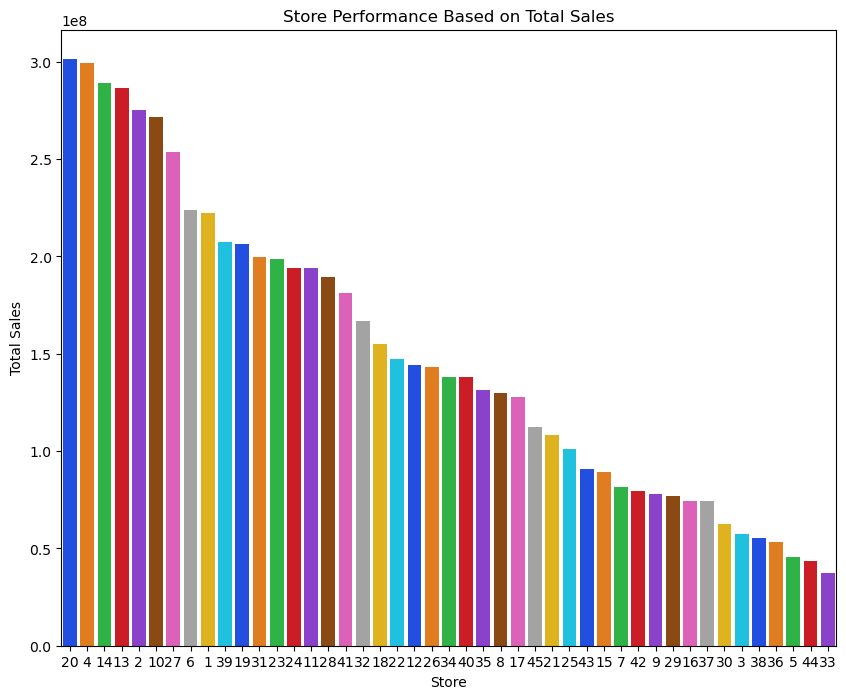

In [58]:
# Store Analysis: Store performance based on Total Sales
store_total_sales = df.groupby('Store')['Weekly_Sales'].sum().reset_index()
sorted_store_total_sales = store_total_sales.sort_values('Weekly_Sales', ascending=False)

# Set the figure size for the plot
plt.figure(figsize=(10, 8))

# Create the barplot
sns.barplot(data=sorted_store_total_sales, x='Store', y='Weekly_Sales',
            palette='bright', order=sorted_store_total_sales['Store'])

# Setting the title and labels
plt.title('Store Performance Based on Total Sales')
plt.xlabel('Store')
plt.ylabel('Total Sales')

# Show the plot
plt.show()


In [59]:
# Group by store and sum the weekly sales
total_sales_by_store = df2.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)

# Display the top performing stores
top_performing_stores = total_sales_by_store.head(45)
print(top_performing_stores)


Store
20    3.013978e+08
4     2.995440e+08
14    2.889999e+08
13    2.865177e+08
2     2.753824e+08
10    2.716177e+08
27    2.538559e+08
6     2.237561e+08
1     2.224028e+08
39    2.074455e+08
19    2.066349e+08
31    1.996139e+08
23    1.987506e+08
24    1.940160e+08
11    1.939628e+08
28    1.892637e+08
41    1.813419e+08
32    1.668192e+08
18    1.551147e+08
22    1.470756e+08
12    1.442872e+08
26    1.434164e+08
34    1.382498e+08
40    1.378703e+08
35    1.315207e+08
8     1.299512e+08
17    1.277821e+08
45    1.123953e+08
21    1.081179e+08
25    1.010612e+08
43    9.056544e+07
15    8.913368e+07
7     8.159828e+07
42    7.956575e+07
9     7.778922e+07
29    7.714155e+07
16    7.425243e+07
37    7.420274e+07
30    6.271689e+07
3     5.758674e+07
38    5.515963e+07
36    5.341221e+07
5     4.547569e+07
44    4.329309e+07
33    3.716022e+07
Name: Weekly_Sales, dtype: float64


<h2 style ="color:RED;"> 1e. ANSWER BELOW:</h2>

Mean Sales: $290,368,360.39
Median Sales: $288,999,911.34
Standard Deviation: $10,572,580.91
Coefficient of Variation: 0.04
Absolute Difference: $26,015,351.48
Percentage Difference: 8.63%


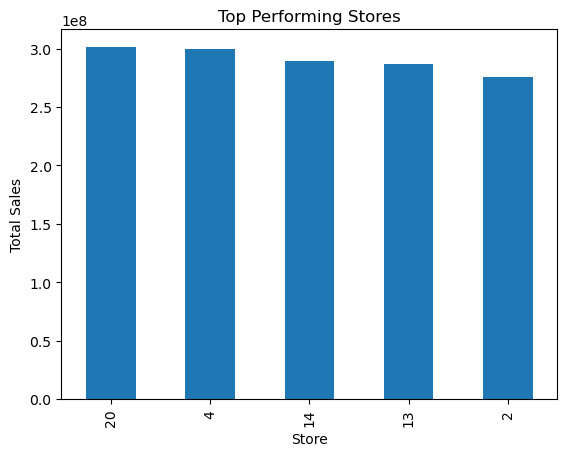

In [60]:
# Top performing stores
top_stores = total_sales_by_store.head(5)

# Calculate statistical measures
mean_sales = top_stores.mean()
median_sales = top_stores.median()
std_deviation = top_stores.std()
coefficient_of_variation = std_deviation / mean_sales

# Absolute and percentage differences
abs_diff = top_stores.max() - top_stores.min()
perc_diff = (abs_diff / top_stores.max()) * 100

# Print statistical analysis
print(f"Mean Sales: ${mean_sales:,.2f}")
print(f"Median Sales: ${median_sales:,.2f}")
print(f"Standard Deviation: ${std_deviation:,.2f}")
print(f"Coefficient of Variation: {coefficient_of_variation:.2f}")
print(f"Absolute Difference: ${abs_diff:,.2f}")
print(f"Percentage Difference: {perc_diff:.2f}%")

# Bar chart for top performing stores
top_stores.plot(kind='bar')
plt.title('Top Performing Stores')
plt.ylabel('Total Sales')
plt.xlabel('Store')
plt.show()


In [61]:
# top 5 stores by historic sales data
total_sales_by_store.head(5)

Store
20    3.013978e+08
4     2.995440e+08
14    2.889999e+08
13    2.865177e+08
2     2.753824e+08
Name: Weekly_Sales, dtype: float64

* Store 20 is the highest performing store with 4,14,13 and 2 following to round off the top 5 performing stores by sales.

<h2 style ="color:RED;"> 1f. QUESTION: The worst performing store, and how significant is the difference between the highest and lowest performing stores. </h2>

In [62]:
# top 5 stores by historic sales data
print(total_sales_by_store.head(1))
print(total_sales_by_store.tail(1))

Store
20    3.013978e+08
Name: Weekly_Sales, dtype: float64
Store
33    37160221.96
Name: Weekly_Sales, dtype: float64


In [81]:
# First, let's format the sales figures in dollars and without scientific notation.

# Convert sales figures to a more readable format (in millions of dollars) and round off to two decimal places
total_sales_by_store_dollars = total_sales_by_store.apply(lambda x: "${:,.2f}".format(x))

# Display the top performing store and the lowest performing store in formatted output
top_store = total_sales_by_store_dollars.head(1)
lowest_store = total_sales_by_store_dollars.tail(1)

# Print the formatted sales figures
print("Top Performing Store:\n", top_store)
print("\nLowest Performing Store:\n", lowest_store)



Top Performing Store:
 Store
20    $301,397,792.46
Name: Weekly_Sales, dtype: object

Lowest Performing Store:
 Store
33    $37,160,221.96
Name: Weekly_Sales, dtype: object


In [85]:
# Assuming total_sales_by_store contains the total sales for each store
# Let's calculate the difference between the highest and lowest performing stores in dollars

# Extracting the sales figures for the top and lowest performing stores
top_store_sales = total_sales_by_store.max()
lowest_store_sales = total_sales_by_store.min()

# Calculating the difference
diff_sales = top_store_sales - lowest_store_sales

# Formatting the result in dollars with two decimal places
Amountdiff = "${:,.2f}".format(diff_sales)

Amountdiff



'$264,237,570.50'

In [87]:
# Calculate mean and standard deviation of sales
mean_sales = total_sales_by_store.mean()
std_dev_sales = total_sales_by_store.std()

# Get the sales figures for the top and lowest performing stores
top_store_sales = total_sales_by_store.max()
lowest_store_sales = total_sales_by_store.min()

# Calculate how many standard deviations the top and lowest stores are from the mean
top_store_std_dev = (top_store_sales - mean_sales) / std_dev_sales
lowest_store_std_dev = (lowest_store_sales - mean_sales) / std_dev_sales

# Format and print the results
print(f"Top performing store is {top_store_std_dev:.2f} standard deviations above the mean")
print(f"Lowest performing store is {lowest_store_std_dev:.2f} standard deviations below the mean")


Top performing store is 1.94 standard deviations above the mean
Lowest performing store is -1.44 standard deviations below the mean


<h2 style ="color:RED;"> 1f. Answer: </h2>

*  The top performing store is store 20 with sales
$301,397,792.46

*  The lowest performing store is store 33 with sales $37,160,221.96

* There is a difference of $264,237,570.50 in sales between the two stores.

* The difference in each store's standard deviation further explains their position relative to each other store 20 - 1.944 from the mean, store 33 is -1.44 from the mean

In [66]:
# Initialize two dictionaries to store forecasts and model metrics
forecasts = {}
model_metrics = {}

In [67]:
# If you want to run only a few specific stores
# selected_stores = [7]  # Add or remove store IDs as needed

# Loop through each store in the selected list
# for store_id in selected_stores:
#    print(f"Processing Store {store_id}")
#    store_data = df[df['Store'] == store_id]


# Loop through each unique store ID
for store_id in df['Store'].unique():
    print(f"Processing Store {store_id}")
    store_data = df[df['Store'] == store_id]

    # Fit ARIMA model and find the best order
    arima_model = auto_arima(store_data['Weekly_Sales'], trace=True)
    order = arima_model.order
    sorder = (arima_model.seasonal_order[0], arima_model.seasonal_order[1], arima_model.seasonal_order[2], 52)

    # Fit SARIMAX model using the best parameters
    sarimax_model = SARIMAX(store_data['Weekly_Sales'], order=order, seasonal_order=sorder)
    sarimax_model_fit = sarimax_model.fit(disp=False)

    # Forecast the next 12 weeks
    forecast = sarimax_model_fit.forecast(steps=12)
    forecasts[store_id] = forecast

    # Store model metrics
    model_metrics[store_id] = {
        'AIC': sarimax_model_fit.aic,
        'BIC': sarimax_model_fit.bic,
    }

# Convert the forecasts dictionary to a DataFrame
forecast_df = pd.DataFrame(forecasts)

# Transpose the DataFrame so that each store's forecast is in a column
forecast_df = forecast_df.T
forecast_df.reset_index(inplace=True)
forecast_df.rename(columns={'index': 'Store'}, inplace=True)

# Convert the model metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(model_metrics).T

# Display the first few rows of the forecast DataFrame
print(forecast_df.head())

# Display the first few rows of the model metrics DataFrame
print(metrics_df.head())


Processing Store 1
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3819.024, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3850.005, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3838.724, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3831.432, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3848.013, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3819.410, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3821.284, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3817.475, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3818.117, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3810.990, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3809.486, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3810.431, Time=0.09 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3810.637, Time=0.21 sec
 ARIMA(1,1,4)(0,0,0

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3636.887, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3635.576, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3634.959, Time=0.17 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3636.384, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3636.583, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3635.761, Time=0.16 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3633.319, Time=0.32 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=3634.799, Time=0.33 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=3638.697, Time=0.22 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3634.757, Time=0.20 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=3639.555, Time=0.15 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=3631.146, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3634.577, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=3634.374, Time=0.19 sec
 ARIMA(5,1,3)(0

 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3969.891, Time=0.24 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 2.977 seconds
Processing Store 15
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3729.901, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3754.934, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3726.815, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3736.307, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4229.072, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3727.517, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3727.926, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3729.533, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3774.355, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.469 seconds
Processing Store 16
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3593.907, Time=0.1

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3840.427, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3899.539, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.474 seconds
Processing Store 25
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3689.600, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3736.405, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3686.335, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3706.235, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4263.360, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3686.773, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3687.159, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3688.787, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3723.925, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.500 seconds
Processing Store 26
Performing stepwise search to minimiz

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3705.279, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3704.226, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3707.224, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.550 seconds
Processing Store 35
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3849.715, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3884.234, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3864.769, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3853.527, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3882.260, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3856.026, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3856.248, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3838.177, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3840.115, Time=0.15 sec
 ARIMA(

 ARIMA(0,0,5)(0,0,0)[0] intercept   : AIC=3733.024, Time=0.10 sec
 ARIMA(1,0,5)(0,0,0)[0] intercept   : AIC=3734.823, Time=0.12 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=4228.515, Time=0.05 sec

Best model:  ARIMA(0,0,4)(0,0,0)[0] intercept
Total fit time: 2.253 seconds
Processing Store 41
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3834.655, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3875.138, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3850.659, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3840.238, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3873.151, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3841.787, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3841.410, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3828.152, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3831.055, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3832.635, Time=0.17 sec
 A

### While it was not requested - we will forecast the sales for the next 12 weeks for all the stores combined

In [69]:
# Aggregate weekly sales across all stores
total_weekly_sales = df.groupby(df.index)['Weekly_Sales'].sum()

<Axes: xlabel='Date'>

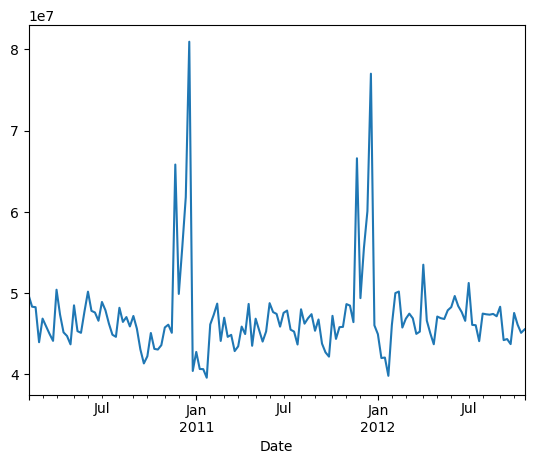

In [70]:
# You can plot the aggregated sales to visualize the trend and seasonality
total_weekly_sales.plot()

<Axes: xlabel='Date'>

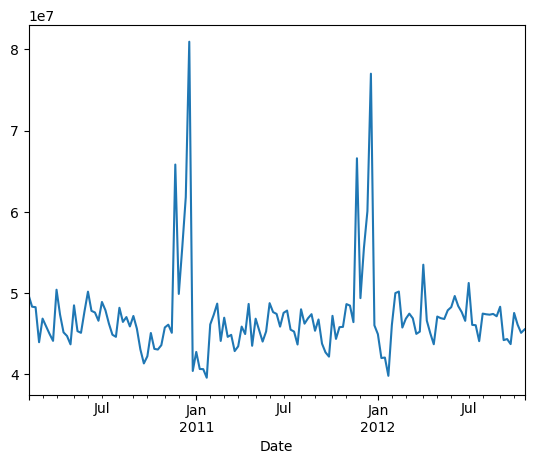

In [71]:
#plot of the aggregated sales to visualize the trend and seasonality
total_weekly_sales.plot()

In [72]:
# Find the best ARIMA model for the aggregated sales
total_sales_arima_model = auto_arima(total_weekly_sales, seasonal=True, m=52, trace=True)
print(f"Best model for total sales: {total_sales_arima_model.order}, Seasonal Order: {total_sales_arima_model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=4769.760, Time=3.33 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=4844.691, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=4804.381, Time=0.50 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=4797.927, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=5462.768, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=4767.813, Time=2.08 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=4830.548, Time=0.21 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=4769.801, Time=9.57 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=4772.937, Time=14.10 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=4777.852, Time=1.65 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=4779.475, Time=2.17 sec
 ARIMA(3,0,2)(1,0,0)[52] intercept   : AIC=4769.157, Time=2.62 sec
 ARIMA(2,0,3)(1,0,0)[52] intercept   : AIC=4779.845, Time=2.14 sec
 ARIMA(1,0,1)(1,0,0)[52

In [73]:
# Fit SARIMAX model using the best parameters from auto_arima
order = total_sales_arima_model.order
sorder = (total_sales_arima_model.seasonal_order[0], total_sales_arima_model.seasonal_order[1], total_sales_arima_model.seasonal_order[2], 52)


In [74]:
sarimax_model = SARIMAX(total_weekly_sales, order=order, seasonal_order=sorder)
sarimax_model_fit = sarimax_model.fit(disp=False)

In [75]:
# Forecast the next 12 weeks
forecast = sarimax_model_fit.forecast(steps=12)

In [76]:
# Print the forecast for total sales
print("Forecast for total sales:")
print(forecast)

Forecast for total sales:
2012-11-02    4.755953e+07
2012-11-09    4.741271e+07
2012-11-16    4.587478e+07
2012-11-23    5.970213e+07
2012-11-30    4.774498e+07
2012-12-07    5.194523e+07
2012-12-14    5.494172e+07
2012-12-21    6.652272e+07
2012-12-28    4.512529e+07
2013-01-04    4.432135e+07
2013-01-11    4.220409e+07
2013-01-18    4.218352e+07
Freq: W-FRI, Name: predicted_mean, dtype: float64


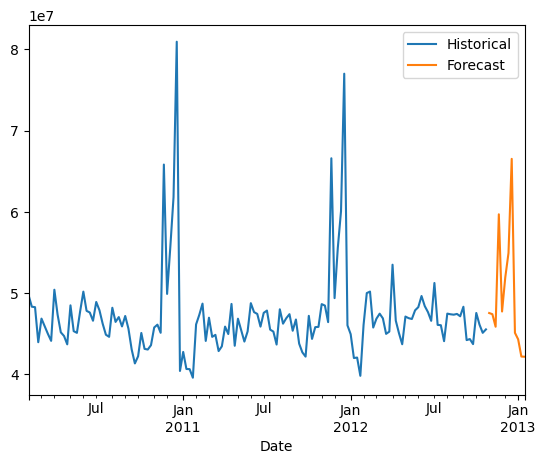

In [77]:
# Plotting the forecast along with the historical data
total_weekly_sales.plot(label='Historical')
forecast.plot(label='Forecast')
plt.legend()
plt.show()


In [ ]:
x